# Zadanie z predmetu IAU - Inteligentna analyza udajov  
# 2. etapa - Predspracovanie  
### Autori: Michal Kabac, Tadeas Drahovsky  
Percentualny podiel 50%, 50%  
testovacia sada cislo 33

In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime
from datetime import datetime,date
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import json
import re
import dateutil.parser as parser
import statsmodels.api as sm
import sqlite3
import sklearn
from missingpy import KNNImputer
import category_encoders as ce
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import Imputer

In [13]:
other_data_train = pd.read_csv("33/other_train.csv")
personal_data_train = pd.read_csv("33/personal_train.csv")

In [14]:
personal_data_train.columns

Index(['Unnamed: 0', 'name', 'address', 'age', 'sex', 'date_of_birth'], dtype='object')

In [15]:
other_data_train.columns

Index(['Unnamed: 0', 'name', 'address', 'kurtosis_oxygen', 'occupation',
       'marital-status', 'pregnant', 'education-num', 'relationship',
       'std_oxygen', 'capital-gain', 'skewness_oxygen', 'education', 'fnlwgt',
       'class', 'income', 'medical_info', 'native-country', 'capital-loss',
       'mean_oxygen', 'hours-per-week', 'race', 'workclass'],
      dtype='object')

In [16]:
# year and age must be string and not NaN
def age_from_year(data_frame, year_column, age_column):
    for i in range(len(data_frame[year_column])):
        if isinstance(data_frame[year_column][i], str):
            year = re.sub(r'[^0-9]', '', data_frame[year_column][i])
            if year != '':
                new_age = 2019 - int(year)
                data_frame.loc[i, age_column] = str(new_age)
    return data_frame

Vo funkcií age_from_year sa do data_frame doplní vypočítaný vek na základe roku narodenia. Vypočítaný vek je vzhľadom na aktuálny rok 2019. Pokiaľ rok v data_frame je NaN, tak sa ignoruje.

In [17]:
# year and age must be string and not NaN
def fix_year_on_age(data_frame, year_column, age_column):
    for i in range(len(data_frame[year_column])):
        if isinstance(data_frame[year_column][i], str) and isinstance(data_frame[age_column][i], str):
            age = re.sub(r'[^0-9]', '', data_frame[age_column][i])
            year = re.sub(r'[^0-9]', '', data_frame[year_column][i])
            if age != '' and year != '' and int(age) != (2019 - int(year)) and int(age) > 0:
                new_year = 2019 - int(age)
                data_frame.loc[i, year_column] = str(new_year)
    return data_frame

Vo funkcii fix_year_on_age sa kontroluje, či sedí daný rok s vekom. Vek je počítaný vzhľadom na aktuálny rok 2019. 
Pokiaľ rok alebo vek v data_frame je NaN, tak sa ignoruje.

In [18]:
def fix_date(data_frame, column):
    for i in range(len(data_frame[column])):
        if isinstance(data_frame[column][i], str):
            new_date = re.sub(r'[\-\:\/]', '-', data_frame[column][i])
            new_date = re.sub(r'[^0-9\-]', '', new_date)
            data_frame.loc[i, column] = new_date[:10]
        else:
            data_frame.loc[i, column] = ''
    return data_frame

Vo funkcii fix_date sa z dátumu odstraňujú všetky špeciálne znaky okrem "-". Taktiež sa rušia časové údaje a ostávajú iba dni, mesiace a roky. Medzi nimi sú "-" a záznamy sa uložia do data_frame.

In [19]:
def null_date(data_frame, column):
    for i in range(len(data_frame[column])):
        if isinstance(data_frame[column][i], str):
            new_date = re.sub(r'[0-9]', '0', data_frame[column][i])
            data_frame.loc[i, column] = new_date
        else:
            data_frame.loc[i, column] = ''
    return data_frame

Vo funkcii null_date sa číselné údaje z dátumov prehodia na 0. Funkcia nám slúžila ako pomocná funkcia na získanie všetkých formátov času.

In [20]:
# iba pre formaty 00-00-00, 0000-00-00, 00-00-0000
def date_to_year(data_frame, column):
    for i in range(len(data_frame[column])):
        if isinstance(data_frame[column][i], str):
            new_date = data_frame[column][i]
            if new_date[4] != '-' and len(new_date) != 8:
                new_date = new_date[6:]
            if len(new_date) == 8:
                if int(new_date[:2]) > 31 or int(new_date[6:]) > 19:
                    new_date = '19' + new_date[:2]
                else:
                    new_date = '19' + new_date[6:]
            data_frame.loc[i, column] = new_date[:4]
        else:
            data_frame.loc[i, column] = ''
    return data_frame

Vo funkcii date_to_year sa z dátumov vytiahnú roky. Funkcia spracováva iba formaty 00-00-00, 0000-00-00, 00-00-0000. Pri roku, kde je známe iba posledné dvojčísle, tak sa automaticky dopĺňa "19". Po tejto funkcií je dobré spúšťať funkciu, ktorá skontroluje roky s vekom, aby si overila, či sa dané doplnenie "19" vykonalo správne a je teda konzistentné s vekom.

In [21]:
def mean_imputer(data_frame, column):
    imp = Imputer(missing_values='NaN', strategy='mean')
    data_frame[column] = imp.fit_transform(data_frame[[column]])
    return data_frame

Vo funkcii sa vypočíta priemer a doplnia sa nulové hodnoty pre prázdne NaN hodnoty. Funkcia využíva Imputer.

In [22]:
def meanFill(data_frame, column):
    mean = data_frame[column].mean()
    data_frame[column].fillna(mean, inplace = True)
    return data_frame

Podobne ako funkcia vyššie ale imputer nebol použitý

In [23]:
class Mode_fill:    
    def __init__(self, data_frame, column):
        self.mode = data_frame[column].mode()
        
    def fit(self):
        return self.mode
    
    def transform(self, data_frame, column):
        data_frame[column].fillna(self.mode, inplace = True)
        return data_frame

In [24]:
class Mean_fill:    
    def __init__(self, data_frame, column):
        self.mean = data_frame[column].mean()
        
    def fit(self):
        return self.mean
    
    def transform(self, data_frame, column):
        data_frame[column].fillna(self.mean, inplace = True)
        return data_frame

Trieda na doplnenie priemeru, vieme si v nej pametat hodnotu priemeru. Pri uprave dat bola pouzita tato trieda

In [25]:
def median_imputer(data_frame, column):
    imp = Imputer(missing_values='NaN', strategy='median')
    data_frame[column] = imp.fit_transform(data_frame[[column]])
    return data_frame

Vo funkcii sa vypočíta medián a doplnia sa nulové hodnoty pre prázdne NaN hodnoty. Funkcia využíva Imputer.

In [26]:
def medianFill(data_frame, column):
    median = data_frame[column].median()
    data_frame[column].fillna(median, inplace = True)
    return data_frame

Podobne ako funkcia vyssie len bez pouzitia imputera

In [27]:
class Median_fill:    
    def __init__(self, data_frame, column):
        self.median = data_frame[column].median()
        
    def fit(self):
        return self.median
    
    def transform(self, data_frame, column):
        data_frame[column].fillna(self.median, inplace = True)
        return data_frame

Trieda na doplnenie medianu, vieme si v nej pametat hodnotu medianu. Pri uprave dat bola pouzita tato trieda

In [28]:
def process_pregnant(data_frame):
    for i in range(len(data_frame.pregnant)):
        value = data_frame.pregnant[i]
        if not value:
            data_frame.at[i, 'pregnant'] = None
        elif value.lower() in ['f', 'false']:
            data_frame.at[i, 'pregnant'] = 'f'
        elif value.lower() in ['t', 'true']:
            data_frame.at[i, 'pregnant'] = 't'
        else:
            data_frame.at[i, 'pregnant'] = None
    return data_frame

Funkcia na nahradenie nekonzistentnych formatov, neskor sme ju prerobili na triedu nizsie s nazvom My_transform

In [29]:
class My_transform(TransformerMixin):
    def __init__(self, column, first, second):
        self.column = column
        self.source = first
        self.target = second
        
    def fit(self, data_frame, y=None, **fit_params):
        return self
    
    def transform(self, data_frame, **transform_params):
        sample = data_frame[self.column] == self.source
        data_frame.loc[sample, self.column] = self.target
        return data_frame

V triede my_transform nahradzame nevhodne formaty , first je nekonzistentny format, second je format na ktory chceme aby bol nekonzistentny format prepisany

In [30]:
def separate(other_data_train):
    data_frame = {}
    med_inf = other_data_train.medical_info
    med_inf = med_inf.str.replace("'", '"').tolist()
    data_keys = json.loads(med_inf[0]).keys()

    for data_key in data_keys:
        data_frame[data_key] = []

    for data in med_inf:
        if isinstance(data, str):
            values = json.loads(data)
            for data_key in data_keys:
                data_frame[data_key].append(values[data_key])
        else:
            for data_key in data_keys:
                data_frame[data_key].append(np.NaN)
    return pd.DataFrame(data_frame)

Funkcia na rozdelenie hodnot v stlpci med_info do viacerych stlpcov

In [31]:
def combine(data_frame):
    data_frame = pd.concat([other_data_train, data_frame.reindex(other_data_train.index)], axis=1)
    data_frame = data_frame.rename(columns={'Unnamed: 0': 'index',})
    data_frame = data_frame.set_index('index')
    return data_frame

Spojenie stlpcov z med_info do povodneho datasetu

In [33]:
def make_positive(df):
    df['hours-per-week'] = df['hours-per-week'].abs()
    df['capital-loss'] = df['capital-loss'].abs()
    df.fnlwgt = df.fnlwgt.abs()
    df['capital-gain'] = df['capital-gain'].abs()
    df['education-num'] = df['education-num'].abs()
    df.kurtosis_oxygen = df.kurtosis_oxygen.abs()
    df.mean_oxygen = df.mean_oxygen.abs()
    df.std_oxygen = df.std_oxygen.abs()
    df.age = df.age.abs()
    df.mean_glucose = df.mean_glucose.abs()
    df.std_glucose = df.std_glucose.abs()
    df.kurtosis_glucose = df.kurtosis_glucose.abs()
    return df

In [34]:
def set_numeric(df):
    df['hours-per-week'] = pd.to_numeric(df['hours-per-week'],errors='coerce')
    df['capital-loss'] = pd.to_numeric(df['capital-loss'],errors='coerce')
    df.fnlwgt = pd.to_numeric(df.fnlwgt,errors='coerce')
    df.skewness_oxygen = pd.to_numeric(df.skewness_oxygen,errors='coerce')
    df['capital-gain'] = pd.to_numeric(df['capital-gain'],errors='coerce')
    df['education-num'] = pd.to_numeric(df['education-num'],errors='coerce')
    df.kurtosis_oxygen = pd.to_numeric(df.kurtosis_oxygen,errors='coerce')    
    
    df.mean_oxygen = pd.to_numeric(df.mean_oxygen,errors='coerce')
    df.std_glucose = pd.to_numeric(df.std_glucose,errors='coerce')
    df.age = pd.to_numeric(df.age,errors='coerce')
    df.mean_glucose = pd.to_numeric(df.mean_glucose,errors='coerce')
    df.std_glucose = pd.to_numeric(df.std_glucose,errors='coerce')
    df.kurtosis_glucose = pd.to_numeric(df.kurtosis_glucose,errors='coerce')
    df.skewness_glucose = pd.to_numeric(df.skewness_glucose,errors='coerce')
    return df

Uprava numerickych atributov, ktore mali typ string na numericke

In [35]:
def find_duplicit(data_frame):
    return data_frame[data_frame.name.isin(data_frame.name[data_frame.name.duplicated()])].sort_values(by=['name'])

Najdenie zaznamov, ktore maju duplicitne zaznami

In [36]:
def fill_duplicit_values(data_frame):
    duplicit_values = find_duplicit(data_frame)  
    prev_line = duplicit_values.loc[duplicit_values.index[0],]
    for index_label, row_series in duplicit_values.iterrows():
        if(row_series['name']==prev_line['name']):
            poz = -1
            for (row1),(row2) in zip(row_series,prev_line):
                poz+=1
                if pd.isna(row1):
                    #data_frame.loc[data_frame.index == index_label,data_frame.columns[poz]] = str(row2)
                    data_frame.at[index_label,data_frame.columns[poz]] = str(row2)
        prev_line = row_series
    return data_frame

Ak je pri duplicite nejaka hodnota v riadku prazdna a v druhom riadku duplicity je, tak si ju zapametame a ulozime

In [37]:
def drop_duplicates(data_frame):
    return data_frame.drop_duplicates(subset=['name','address'], keep='last')


Dropneme vsetky duplicity podla mena a adresy a nechame si poslednu

In [38]:
def connect_datasets(data1,data2):
    conn = sqlite3.connect(':memory:')
    data1.to_sql('data1', conn, index=False)
    data2.to_sql('data2', conn, index=False)

    qry = '''
        select  
            *
        from
            data2 join data1 on data1.name == data2.name
            and data1.address == data2.address
        '''
    return pd.read_sql_query(qry, conn)

Spojenie 2 datasetov do 1 pomocou sql prikazu

In [39]:
def drop_values_1(final_dataset):
    final_dataset.drop(['Unnamed: 0','name','address','medical_info','date_of_birth'], axis=1, inplace=True)
    return final_dataset

Dropnutie zbytocnych stlpcov

In [40]:
def set_pregnant(final_dataset):
    final_dataset.sex = final_dataset.sex.str.strip()
    final_dataset.loc[(final_dataset.sex=='Male' )  & (final_dataset['pregnant'].isnull() ), 'pregnant'] = 'F'
    final_dataset.loc[final_dataset['pregnant'].isnull(), 'pregnant'] = str(final_dataset.pregnant.mode())
    return final_dataset

Kontrola ci je pregnant vase vyplnene. Pri muzoch to vieme urcit hned. V opacnom pripade nechavame najcastejsie sa vyskytujuci prvok. Tato funkcia bola povodna. Na upravu sme pouzili inu

In [41]:
def makeAlphaNum(data_frame, column):
    for i in range(len(data_frame[column])):
        if isinstance(data_frame[column][i], str):
            data_frame.at[i, column] = re.sub(r'[^a-zA-Z0-9]', '', data_frame[column][i]).lower()
        else:
            data_frame.at[i, column] = ''
    return data_frame

Uprava formatu pomocou regexu iba na pismena a cisla(vyuzite pri napr. educational num)

In [42]:
def makeAlpha(data_frame, column):
    for i in range(len(data_frame[column])):
        if isinstance(data_frame[column][i], str):
            data_frame.at[i, column] = re.sub(r'[^a-zA-Z]', '', data_frame[column][i]).lower()
        else:
            data_frame.at[i, column] = ''
    return data_frame

Uprava formatu na pismena, pouzity regex a lowercase

In [43]:
def encode_values(final_dataset):
    encoder = ce.OneHotEncoder(cols=['occupation','marital-status','pregnant','relationship','education','income','native-country','race','workclass','sex'])
    encoder.fit(final_dataset)
    return encoder.transform(final_dataset)

One hot encoder na stlpce, neskor sa este bude prepisovat do class aby som si pametal poradie stlpcov

In [44]:
def data_divide(final_dataset, column):
    x = final_dataset[final_dataset.columns.diffearence([column])]
    y = final_dataset[column]
    return x,y

Rozdelenie datasetu na x a y, v y su labele v x su ostatne data

In [45]:
def fit_knn(final_dataset):
    imputer = KNNImputer(col_max_missing=0.8, copy=True, metric='masked_euclidean',
           missing_values='NaN', n_neighbors=5, row_max_missing=0.5,
           weights='uniform')
    new_imputer = imputer.fit(final_dataset)
    return new_imputer

Natrenovanie knn pre doplnenie chybajucich hodnot, trenujem to iba na testovacich datach.

In [46]:
def fill_na_knn(final_dataset,imputer):
    names = final_dataset.columns
    final_dataset = imputer.transform(final_dataset)
    final_dataset = pd.DataFrame(final_dataset)
    final_dataset.columns = names
    return final_dataset

Doplnenie chybajucich hodnot pomocou tranform a natrenovaneho modelu knn

In [47]:
def log_normalization(final_dataset,column):
    final_dataset[column] = np.log(final_dataset[column])
    return final_dataset

Normalizacia hodnot pomocou logaritmu (na odstranenie outlyerov)

In [48]:
def sqrt_normalization(final_dataset,column):
    final_dataset[column] = np.sqrt(final_dataset[column])
    return final_dataset

Normalizacia hodnot pomocou odmocniny (na odstranenie outlyerov)

In [49]:
def fix_value_constant(final_dataset,column,constant,criteria):
    for i, value in final_dataset.iterrows():
        if value[column] < -criteria:
            final_dataset.loc[final_dataset.index == i, column] = value[column]/(-constant)
        elif value[column] > criteria:
            final_dataset.loc[final_dataset.index == i, column] = value[column]/constant
    return final_dataset
    #std_glucose

Nahradenie zlych hodnot konstantov. Niektore hodnoty su zaporne, tak sa predelia zapornou konstantou

In [50]:
class Quartile(TransformerMixin):
    
    def __init__(self, final_dataset, column):
        self.quartil_down = final_dataset[column].quantile(0.05)
        self.quartil_up = final_dataset[column].quantile(0.95)
        
    def fit(self):
        return self.quartil_down, self.quartil_up
    
    def transform(self, final_dataset, column):
        for i, value in final_dataset.iterrows():
            if value[column] < self.quartil_down:
                final_dataset.loc[i, column] = self.quartil_down
            elif value[column] > self.quartil_up:
                final_dataset.loc[i, column] = self.quartil_up
        return final_dataset

Nahradenie outlyerov hodnotami z 5% a 95% kvartilu, pouzite v triede, takze si pametam hodnoty kvartilov

In [51]:
def set_numeric(df):
    df.mean_oxygen = pd.to_numeric(df.mean_oxygen,errors='coerce')
    df.std_glucose = pd.to_numeric(df.std_glucose,errors='coerce')
    df.age = pd.to_numeric(df.age,errors='coerce')
    df.mean_glucose = pd.to_numeric(df.mean_glucose,errors='coerce')
    df.std_glucose = pd.to_numeric(df.std_glucose,errors='coerce')
    df.kurtosis_glucose = pd.to_numeric(df.kurtosis_glucose,errors='coerce')
    df.skewness_glucose = pd.to_numeric(df.skewness_glucose,errors='coerce')
    df.mean_oxygen = pd.to_numeric(df.age,errors='coerce')
    return df

Uprava stringovych formatov na numericke, v pripadoch kde su cisla

In [52]:
def setAlpha(final_dataset):
    final_dataset = makeAlpha(final_dataset, "occupation")
    final_dataset = makeAlpha(final_dataset, "marital-status")
    final_dataset = makeAlpha(final_dataset, "pregnant")
    final_dataset = makeAlpha(final_dataset, "relationship")
    final_dataset = makeAlphaNum(final_dataset, "education")
    final_dataset = makeAlpha(final_dataset, "income")
    final_dataset = makeAlpha(final_dataset, "native-country")
    final_dataset = makeAlpha(final_dataset, "race")
    final_dataset = makeAlpha(final_dataset, "workclass")
    final_dataset = makeAlpha(final_dataset, "sex")
    return final_dataset

Uprava stringov, lowercase odstranenie specialnych znakov

In [53]:
def drop_class(df,column):
    #final_dataset = final_dataset[final_dataset[column].notna()]
    df = df[np.isfinite(df[column])]
    return df

Odstranenie riadkov kde chybaju labele

In [249]:
def fit_minmax(df, column):
    x = df[[column]].values
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit(df[[column]])

natrenovanie modelu pre minmax normalizaciu

In [237]:
def transform_minmax(df, column,scaler):
    x = df[[column]].values
    x_scaled = scaler.transform(x)
    df[column] = pd.DataFrame(x_scaled)
    return df

Uprava transformaciou

In [405]:
other_data_train.medical_info.head()

0    {'mean_glucose':'79.8359375','std_glucose':'38...
1    {'mean_glucose':'117.46875','std_glucose':'52....
2    {'mean_glucose':'109.0234375','std_glucose':'4...
3    {'mean_glucose':'16.0546875','std_glucose':'-3...
4    {'mean_glucose':'110.1796875','std_glucose':'5...
Name: medical_info, dtype: object

Z vypisu a analyzi vieme ze hodnoty v stlpcoch med info treba rozdeli do viacerych stlpcov

In [406]:
data_frame = separate(other_data_train)
data_frame.head()

mean_glucose   std_glucose    kurtosis_glucose skewness_glucose
0   79.8359375   38.73200738         0.835316999      2.014008974
1    117.46875   52.07505663        -0.041947703     -0.474659038
2  109.0234375   49.13493297         0.322659154      0.131936945
3   16.0546875  -3806.004889         4.992567838      25.49145159
4  110.1796875   50.86462327  0.4802492820000001     -0.024075919

Rozdelenie stlpcov z med info do osobitnych stlpcov

In [407]:
data_frame = combine(data_frame)
data_frame.head()

name                                            address  \
index                                                                       
0        Marco Stanton  958 Smith Pike Suite 249\r\nLake Andrewton, GA...   
1      Benjamin Holman                 Unit 1778 Box 6724\r\nDPO AE 34370   
2      Robert Sullivan           76441 Erin Trail\r\nWest Jared, WI 77001   
3          John Franck           623 Desiree Run\r\nJosephville, MI 23247   
4       David Lackland           8323 Moss Station\r\nJuliefurt, AZ 43882   

       kurtosis_oxygen          occupation       marital-status pregnant  \
index                                                                      
0             9.246478     Exec-managerial   Married-civ-spouse        f   
1            22.091694        Adm-clerical        Never-married        f   
2             5.677978     Exec-managerial        Never-married        f   
3             0.214241               Sales        Never-married        f   
4             8.791325   Machine-op-inspct        Never-married        f   

       education-num     relationship  std_oxygen  capital-gain  ...  \
index                                                            ...   
0               13.0          Husband   14.682571           0.0  ...   
1               10.0   Other-relative    8.827777           0.0  ...   
2               13.0    Not-in-family   31.281121        8614.0  ...   
3                8.0    Not-in-family   65.506380        4650.0  ...   
4                6.0        Own-child   18.180651           0.0  ...   

       native-country capital-loss  mean_oxygen  hours-per-week    race  \
index                                                                     
0       United-States          0.0     2.118729            60.0   White   
1       United-States          0.0     0.671405            40.0   White   
2       United-States          0.0     5.670569            40.0   White   
3       United-States          0.0   125.755853            50.0   White   
4       United-States          0.0     2.556856            40.0   White   

              workclass mean_glucose   std_glucose    kurtosis_glucose  \
index                                                                    
0               Private   79.8359375   38.73200738         0.835316999   
1               Private    117.46875   52.07505663        -0.041947703   
2               Private  109.0234375   49.13493297         0.322659154   
3               Private   16.0546875  -3806.004889         4.992567838   
4      self-emp-not-inc  110.1796875   50.86462327  0.4802492820000001   

       skewness_glucose  
index                    
0           2.014008974  
1          -0.474659038  
2           0.131936945  
3           25.49145159  
4          -0.024075919  

[5 rows x 26 columns]

Spojenie stlpcov z medinfo s datasetom

In [408]:
personal_data_train.head()

Unnamed: 0             name  \
0           0  Roscoe Bohannon   
1           1     Ernest Kline   
2           2  Harold Hendriks   
3           3   Randy Baptiste   
4           4  Anthony Colucci   

                                             address  age      sex  \
0  7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...   48   Female   
1  391 Ball Road Suite 961\r\nFlowersborough, IN ...   69     Male   
2     8702 Vincent Square\r\nNew Jerryfurt, CO 30614   45   Female   
3     2751 Harris Crossroad\r\nWest Ashley, CA 30311  NaN     Male   
4  904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...   23     Male   

         date_of_birth  
0           1971-05-28  
1  1950-02-27 00:00:00  
2           1974-01-18  
3           1955-06-09  
4           1995-11-03

In [409]:
data_frame.head()

name                                            address  \
index                                                                       
0        Marco Stanton  958 Smith Pike Suite 249\r\nLake Andrewton, GA...   
1      Benjamin Holman                 Unit 1778 Box 6724\r\nDPO AE 34370   
2      Robert Sullivan           76441 Erin Trail\r\nWest Jared, WI 77001   
3          John Franck           623 Desiree Run\r\nJosephville, MI 23247   
4       David Lackland           8323 Moss Station\r\nJuliefurt, AZ 43882   

       kurtosis_oxygen          occupation       marital-status pregnant  \
index                                                                      
0             9.246478     Exec-managerial   Married-civ-spouse        f   
1            22.091694        Adm-clerical        Never-married        f   
2             5.677978     Exec-managerial        Never-married        f   
3             0.214241               Sales        Never-married        f   
4             8.791325   Machine-op-inspct        Never-married        f   

       education-num     relationship  std_oxygen  capital-gain  ...  \
index                                                            ...   
0               13.0          Husband   14.682571           0.0  ...   
1               10.0   Other-relative    8.827777           0.0  ...   
2               13.0    Not-in-family   31.281121        8614.0  ...   
3                8.0    Not-in-family   65.506380        4650.0  ...   
4                6.0        Own-child   18.180651           0.0  ...   

       native-country capital-loss  mean_oxygen  hours-per-week    race  \
index                                                                     
0       United-States          0.0     2.118729            60.0   White   
1       United-States          0.0     0.671405            40.0   White   
2       United-States          0.0     5.670569            40.0   White   
3       United-States          0.0   125.755853            50.0   White   
4       United-States          0.0     2.556856            40.0   White   

              workclass mean_glucose   std_glucose    kurtosis_glucose  \
index                                                                    
0               Private   79.8359375   38.73200738         0.835316999   
1               Private    117.46875   52.07505663        -0.041947703   
2               Private  109.0234375   49.13493297         0.322659154   
3               Private   16.0546875  -3806.004889         4.992567838   
4      self-emp-not-inc  110.1796875   50.86462327  0.4802492820000001   

       skewness_glucose  
index                    
0           2.014008974  
1          -0.474659038  
2           0.131936945  
3           25.49145159  
4          -0.024075919  

[5 rows x 26 columns]

In [410]:
data_frame.isna().sum().sum()

336

In [411]:
data_frame = fill_duplicit_values(data_frame)
data_frame = drop_duplicates(data_frame)
data_frame.head()

name                                            address  \
index                                                                       
0        Marco Stanton  958 Smith Pike Suite 249\r\nLake Andrewton, GA...   
1      Benjamin Holman                 Unit 1778 Box 6724\r\nDPO AE 34370   
2      Robert Sullivan           76441 Erin Trail\r\nWest Jared, WI 77001   
3          John Franck           623 Desiree Run\r\nJosephville, MI 23247   
4       David Lackland           8323 Moss Station\r\nJuliefurt, AZ 43882   

       kurtosis_oxygen          occupation       marital-status pregnant  \
index                                                                      
0             9.246478     Exec-managerial   Married-civ-spouse        f   
1            22.091694        Adm-clerical        Never-married        f   
2             5.677978     Exec-managerial        Never-married        f   
3             0.214241               Sales        Never-married        f   
4             8.791325   Machine-op-inspct        Never-married        f   

       education-num     relationship  std_oxygen  capital-gain  ...  \
index                                                            ...   
0               13.0          Husband   14.682571           0.0  ...   
1               10.0   Other-relative    8.827777           0.0  ...   
2               13.0    Not-in-family   31.281121        8614.0  ...   
3                8.0    Not-in-family   65.506380        4650.0  ...   
4                6.0        Own-child   18.180651           0.0  ...   

       native-country capital-loss  mean_oxygen  hours-per-week    race  \
index                                                                     
0       United-States          0.0     2.118729            60.0   White   
1       United-States          0.0     0.671405            40.0   White   
2       United-States          0.0     5.670569            40.0   White   
3       United-States          0.0   125.755853            50.0   White   
4       United-States          0.0     2.556856            40.0   White   

              workclass mean_glucose   std_glucose    kurtosis_glucose  \
index                                                                    
0               Private   79.8359375   38.73200738         0.835316999   
1               Private    117.46875   52.07505663        -0.041947703   
2               Private  109.0234375   49.13493297         0.322659154   
3               Private   16.0546875  -3806.004889         4.992567838   
4      self-emp-not-inc  110.1796875   50.86462327  0.4802492820000001   

       skewness_glucose  
index                    
0           2.014008974  
1          -0.474659038  
2           0.131936945  
3           25.49145159  
4          -0.024075919  

[5 rows x 26 columns]

Doplnenie duplicit (pozeram ci nejaky zaznam ktory chyba v riadku sa nenachadza v inej duplicite, ak sa nachadza tak ho doplnim) a nasledne ponechanie iba 1 zaznamu :D

In [412]:
data_frame.isna().sum().sum()

61

Po odstraneni duplicit vidime ze nam vela chybajucich hodnot vypadlo

In [413]:
final_dataset = connect_datasets(personal_data_train,data_frame)
final_dataset.head()

/Users/michalkabac/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2531: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)


name                                            address  \
0    Marco Stanton  958 Smith Pike Suite 249\r\nLake Andrewton, GA...   
1  Benjamin Holman                 Unit 1778 Box 6724\r\nDPO AE 34370   
2  Robert Sullivan           76441 Erin Trail\r\nWest Jared, WI 77001   
3      John Franck           623 Desiree Run\r\nJosephville, MI 23247   
4   David Lackland           8323 Moss Station\r\nJuliefurt, AZ 43882   

   kurtosis_oxygen          occupation       marital-status pregnant  \
0         9.246478     Exec-managerial   Married-civ-spouse        f   
1        22.091694        Adm-clerical        Never-married        f   
2         5.677978     Exec-managerial        Never-married        f   
3         0.214241               Sales        Never-married        f   
4         8.791325   Machine-op-inspct        Never-married        f   

   education-num     relationship  std_oxygen  capital-gain  ...  \
0           13.0          Husband   14.682571           0.0  ...   
1           10.0   Other-relative    8.827777           0.0  ...   
2           13.0    Not-in-family   31.281121        8614.0  ...   
3            8.0    Not-in-family   65.506380        4650.0  ...   
4            6.0        Own-child   18.180651           0.0  ...   

   mean_glucose   std_glucose    kurtosis_glucose  skewness_glucose  \
0    79.8359375   38.73200738         0.835316999       2.014008974   
1     117.46875   52.07505663        -0.041947703      -0.474659038   
2   109.0234375   49.13493297         0.322659154       0.131936945   
3    16.0546875  -3806.004889         4.992567838       25.49145159   
4   110.1796875   50.86462327  0.4802492820000001      -0.024075919   

  Unnamed: 0             name  \
0       1930    Marco Stanton   
1       3750  Benjamin Holman   
2       1389  Robert Sullivan   
3       2048      John Franck   
4       3498   David Lackland   

                                             address  age      sex  \
0  958 Smith Pike Suite 249\r\nLake Andrewton, GA...   70     Male   
1                 Unit 1778 Box 6724\r\nDPO AE 34370   35   Female   
2           76441 Erin Trail\r\nWest Jared, WI 77001   58     Male   
3           623 Desiree Run\r\nJosephville, MI 23247   69     Male   
4           8323 Moss Station\r\nJuliefurt, AZ 43882   47     Male   

         date_of_birth  
0           1949-02-10  
1           1984-02-29  
2           1960/12/09  
3  1950-02-15 00:00:00  
4  1971-12-01 00 00 00  

[5 rows x 32 columns]

Spojenie 2 datasetov spolu, spojenie robime cez meno a adresu aby to bolo presnejsie :D

In [414]:
final_dataset

name                                            address  \
0            Marco Stanton  958 Smith Pike Suite 249\r\nLake Andrewton, GA...   
1          Benjamin Holman                 Unit 1778 Box 6724\r\nDPO AE 34370   
2          Robert Sullivan           76441 Erin Trail\r\nWest Jared, WI 77001   
3              John Franck           623 Desiree Run\r\nJosephville, MI 23247   
4           David Lackland           8323 Moss Station\r\nJuliefurt, AZ 43882   
5         George Esperanza            768 Lori Port\r\nBenjaminfurt, LA 20386   
6          Johnny Reynolds       326 Jose Junction\r\nPort Nicholas, MN 93755   
7            Andrew Bryson  091 Melissa Mount Apt. 387\r\nSamuelfurt, UT 9...   
8                John Renk                 Unit 5533 Box 2757\r\nDPO AE 13245   
9             Eric Marquez                         USS Golden\r\nFPO AP 12414   
10           Michael Kowal  4784 Walters Extensions\r\nEast Whitney, NH 27458   
11           Armando Welch  3508 Holden Neck Suite 181\r\nClarkfurt, TX 04627   
12      Christopher Teague    802 Lindsay Way Apt. 981\r\nPort Ryan, AR 18634   
13           Thomas Bowman   7974 Rodriguez Ridge\r\nNew Eugeneview, PA 93219   
14        Scott Carrington       132 Catherine Knolls\r\nDanielstad, NJ 80886   
15            Harvey Lyons     80117 Ramos Spring\r\nPort Peterland, MA 56905   
16                Sean Hsu                 PSC 5085, Box 5674\r\nAPO AA 84715   
17             Gary Mulzer    859 Dylan Run Apt. 692\r\nTranchester, NE 05230   
18            Isiah Haynes           366 Gregory Trace\r\nPort Jack, IN 39433   
19    Christopher Ferguson  19247 Webster Station Suite 385\r\nMelissamout...   
20             Arthur Zack                 PSC 1224, Box 4018\r\nAPO AA 68060   
21             John Phipps   523 Valencia Port\r\nLake Caitlinhaven, CO 23919   
22            Hyman Torres    8248 Christopher Walks\r\nGilbertview, MI 79649   
23          David Williams  348 David Hills Apt. 602\r\nMercerburgh, NM 29934   
24          Michael Miller  114 Cook Turnpike\r\nLake Marcuschester, PA 35764   
25             Jason Tabor                 Unit 6298 Box 8573\r\nDPO AE 86061   
26          Stephen Harris      60752 Kimberly Squares\r\nTanyafort, LA 55055   
27                Tony Lee        3874 Adams Alley\r\nNew Danielton, NY 38772   
28            Patrick Holt             82524 Amy Lodge\r\nNorth Amy, KS 00656   
29          Richard Salada  28481 David Cliffs Suite 023\r\nMckinneyhaven,...   
...                    ...                                                ...   
3903       Jesus Alexander             024 Karen Pass\r\nEast Henry, MT 94400   
3904      Clemente Padilla           8509 Jorge Vista\r\nHannahfort, CO 87770   
3905         Roger Pilling                 PSC 1164, Box 1307\r\nAPO AP 47559   
3906      Santiago Edmonds  01097 Allison Summit Apt. 882\r\nPort Jennifer...   
3907           David Hodge   193 Lamb Parks Suite 442\r\nPort Marie, GA 16697   
3908         Roger Navarro              6708 Lee Ports\r\nWest Gina, IA 48805   
3909          Mike Webster  707 Lonnie River Suite 245\r\nNorth Haleyland,...   
3910    Heriberto Bazemore                 PSC 2031, Box 9334\r\nAPO AA 54662   
3911        Theodore Green      3226 Jones Flats\r\nEast Martinport, MD 38610   
3912        Richard Vargas         79011 Lori Point\r\nNew Juanland, OR 99480   
3913           Billy Pitts  7832 Michele Meadow Apt. 996\r\nEast Lance, KY...   
3914         James Huffman        535 Michael Squares\r\nNorth Sara, ID 61368   
3915         Matthew Terry  58905 Amy Corner Suite 499\r\nMorganbury, OK 3...   
3916          Joel Blanton  16843 Thomas Inlet Apt. 693\r\nNorth Erinhaven...   
3917        William Wright   403 Marcia Islands\r\nSouth Nancyburgh, HI 70158   
3918            Paul Corey                 PSC 2244, Box 6510\r\nAPO AE 22370   
3919       Ezequiel Dunham        909 Edward Tunnel\r\nNorth Lauren, GA 66712   
3920        Brad Hernandez   76725 Jill View Apt. 139

In [415]:
d = 'date_of_birth'
a = 'age'
final_dataset.pipe(fix_date, d).pipe(date_to_year, d).pipe(fix_year_on_age, d, a).pipe(age_from_year, d, a)

name                                            address  \
0            Marco Stanton  958 Smith Pike Suite 249\r\nLake Andrewton, GA...   
1          Benjamin Holman                 Unit 1778 Box 6724\r\nDPO AE 34370   
2          Robert Sullivan           76441 Erin Trail\r\nWest Jared, WI 77001   
3              John Franck           623 Desiree Run\r\nJosephville, MI 23247   
4           David Lackland           8323 Moss Station\r\nJuliefurt, AZ 43882   
5         George Esperanza            768 Lori Port\r\nBenjaminfurt, LA 20386   
6          Johnny Reynolds       326 Jose Junction\r\nPort Nicholas, MN 93755   
7            Andrew Bryson  091 Melissa Mount Apt. 387\r\nSamuelfurt, UT 9...   
8                John Renk                 Unit 5533 Box 2757\r\nDPO AE 13245   
9             Eric Marquez                         USS Golden\r\nFPO AP 12414   
10           Michael Kowal  4784 Walters Extensions\r\nEast Whitney, NH 27458   
11           Armando Welch  3508 Holden Neck Suite 181\r\nClarkfurt, TX 04627   
12      Christopher Teague    802 Lindsay Way Apt. 981\r\nPort Ryan, AR 18634   
13           Thomas Bowman   7974 Rodriguez Ridge\r\nNew Eugeneview, PA 93219   
14        Scott Carrington       132 Catherine Knolls\r\nDanielstad, NJ 80886   
15            Harvey Lyons     80117 Ramos Spring\r\nPort Peterland, MA 56905   
16                Sean Hsu                 PSC 5085, Box 5674\r\nAPO AA 84715   
17             Gary Mulzer    859 Dylan Run Apt. 692\r\nTranchester, NE 05230   
18            Isiah Haynes           366 Gregory Trace\r\nPort Jack, IN 39433   
19    Christopher Ferguson  19247 Webster Station Suite 385\r\nMelissamout...   
20             Arthur Zack                 PSC 1224, Box 4018\r\nAPO AA 68060   
21             John Phipps   523 Valencia Port\r\nLake Caitlinhaven, CO 23919   
22            Hyman Torres    8248 Christopher Walks\r\nGilbertview, MI 79649   
23          David Williams  348 David Hills Apt. 602\r\nMercerburgh, NM 29934   
24          Michael Miller  114 Cook Turnpike\r\nLake Marcuschester, PA 35764   
25             Jason Tabor                 Unit 6298 Box 8573\r\nDPO AE 86061   
26          Stephen Harris      60752 Kimberly Squares\r\nTanyafort, LA 55055   
27                Tony Lee        3874 Adams Alley\r\nNew Danielton, NY 38772   
28            Patrick Holt             82524 Amy Lodge\r\nNorth Amy, KS 00656   
29          Richard Salada  28481 David Cliffs Suite 023\r\nMckinneyhaven,...   
...                    ...                                                ...   
3903       Jesus Alexander             024 Karen Pass\r\nEast Henry, MT 94400   
3904      Clemente Padilla           8509 Jorge Vista\r\nHannahfort, CO 87770   
3905         Roger Pilling                 PSC 1164, Box 1307\r\nAPO AP 47559   
3906      Santiago Edmonds  01097 Allison Summit Apt. 882\r\nPort Jennifer...   
3907           David Hodge   193 Lamb Parks Suite 442\r\nPort Marie, GA 16697   
3908         Roger Navarro              6708 Lee Ports\r\nWest Gina, IA 48805   
3909          Mike Webster  707 Lonnie River Suite 245\r\nNorth Haleyland,...   
3910    Heriberto Bazemore                 PSC 2031, Box 9334\r\nAPO AA 54662   
3911        Theodore Green      3226 Jones Flats\r\nEast Martinport, MD 38610   
3912        Richard Vargas         79011 Lori Point\r\nNew Juanland, OR 99480   
3913           Billy Pitts  7832 Michele Meadow Apt. 996\r\nEast Lance, KY...   
3914         James Huffman        535 Michael Squares\r\nNorth Sara, ID 61368   
3915         Matthew Terry  58905 Amy Corner Suite 499\r\nMorganbury, OK 3...   
3916          Joel Blanton  16843 Thomas Inlet Apt. 693\r\nNorth Erinhaven...   
3917        William Wright   403 Marcia Islands\r\nSouth Nancyburgh, HI 70158   
3918            Paul Corey                 PSC 2244, Box 6510\r\nAPO AE 22370   
3919       Ezequiel Dunham        909 Edward Tunnel\r\nNorth Lauren, GA 66712   
3920        Brad Hernandez   76725 Jill View Apt. 139

Uprava datumu a dopocitanie veku

In [416]:
ppl = Pipeline([
                ('first',  My_transform('pregnant', 'TRUE', 't')),
                ('second', My_transform('pregnant', 'T', 't')),
                ('third',  My_transform('pregnant', 'FALSE', 'f')),
                ('fourth', My_transform('pregnant', 'F', 'f'))
                ])

model = ppl.fit(final_dataset)
final_dataset = model.transform(final_dataset)

Upravenie formatov pomocou pipeliny

<img src="https://scontent.fbts2-1.fna.fbcdn.net/v/t1.15752-9/76773232_639980893202737_6786163956789542912_n.png?_nc_cat=107&_nc_ohc=DA5zRkyip1sAQlwZydgcXyRJvboxLsd2PIg2YouOrvY46iR4uKmtt7ewA&_nc_ht=scontent.fbts2-1.fna&oh=e3e7a80881fd8fb713b997942abbfcaf&oe=5E4D23AB">

Graf ako vyzerali formati pred upravou

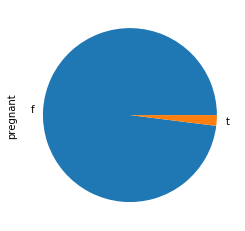

In [417]:
final_dataset.pregnant.value_counts().plot(kind='pie')

Graf po uprave

In [418]:
final_dataset = drop_values_1(final_dataset)

Odstranenie zbytocnych hodnot

In [419]:
final_dataset.dtypes

kurtosis_oxygen     float64
occupation           object
marital-status       object
pregnant             object
education-num       float64
relationship         object
std_oxygen          float64
capital-gain        float64
skewness_oxygen     float64
education            object
fnlwgt              float64
class               float64
income               object
native-country       object
capital-loss        float64
mean_oxygen         float64
hours-per-week      float64
race                 object
workclass            object
mean_glucose         object
std_glucose          object
kurtosis_glucose     object
skewness_glucose     object
age                  object
sex                  object
dtype: object

In [426]:
final_dataset = set_numeric(final_dataset)

nastavenie formatov ktore su string na numericke

In [428]:
final_dataset.dtypes

kurtosis_oxygen     float64
occupation           object
marital-status       object
pregnant             object
education-num       float64
relationship         object
std_oxygen          float64
capital-gain        float64
skewness_oxygen     float64
education            object
fnlwgt              float64
class               float64
income               object
native-country       object
capital-loss        float64
mean_oxygen           int64
hours-per-week      float64
race                 object
workclass            object
mean_glucose        float64
std_glucose         float64
kurtosis_glucose    float64
skewness_glucose    float64
age                   int64
sex                  object
dtype: object

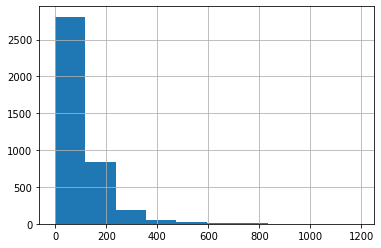

In [429]:
final_dataset.skewness_oxygen.hist()

In [430]:
final_dataset = log_normalization(final_dataset,'skewness_oxygen')

/Users/michalkabac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


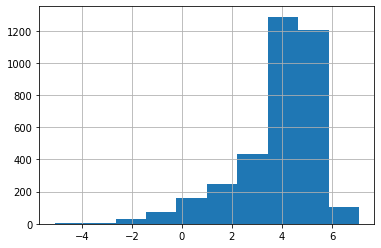

In [431]:
final_dataset.skewness_oxygen.hist()

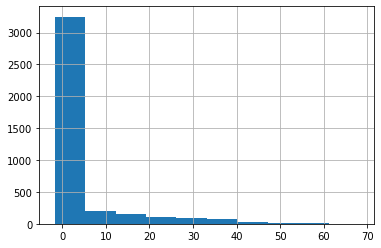

In [432]:
final_dataset.skewness_glucose.hist()

In [433]:
final_dataset = sqrt_normalization(final_dataset,'skewness_glucose')

/Users/michalkabac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


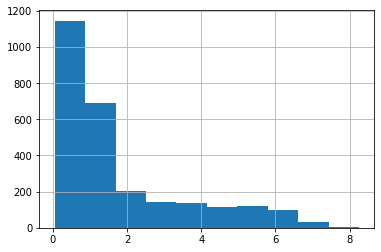

In [434]:
final_dataset.skewness_glucose.hist()

In [435]:
final_dataset.describe()

kurtosis_oxygen  education-num   std_oxygen  capital-gain  \
count      3930.000000    3929.000000  3931.000000   3930.000000   
mean          7.413003      10.146348    31.146892   1019.984478   
std           4.813438       2.552347    22.260920   7306.873040   
min          -2.597872       1.000000     7.370432      0.000000   
25%           3.633111       9.000000    15.041117      0.000000   
50%           7.781903      10.000000    20.567593      0.000000   
75%          10.267074      13.000000    43.175249      0.000000   
max          34.539844      16.000000   110.642211  99999.000000   

       skewness_oxygen         fnlwgt        class  capital-loss  mean_oxygen  \
count      3553.000000    3928.000000  3928.000000   3929.000000  3933.000000   
mean          3.871793  186211.480906     0.255601     86.036142    51.837274   
std           1.635018  104023.945830     0.436254    396.421959    11.814520   
min          -5.082515   14878.000000     0.000000      0.000000     1.000000   
25%           3.311132  114685.750000     0.000000      0.000000    44.000000   
50%           4.361113  175867.000000     0.000000      0.000000    52.000000   
75%           4.896758  235453.250000     1.000000      0.000000    60.000000   
max           7.082549  889965.000000     1.000000   2824.000000   113.000000   

       hours-per-week  mean_glucose  std_glucose  kurtosis_glucose  \
count     3925.000000   3540.000000  3933.000000       3933.000000   
mean        40.051975    101.470518    40.186242          0.951283   
std         12.469529     33.547384  1455.567795          1.610970   
min          1.000000      6.187500 -6892.691548         -1.641515   
25%         39.000000     88.101562    39.247611          0.072144   
50%         40.000000    110.863281    45.837135          0.310784   
75%         45.000000    124.306641    50.976229          0.776762   
max         99.000000    189.734375  6099.616917          8.069522   

       skewness_glucose          age  
count       2693.000000  3933.000000  
mean           1.793125    51.837274  
std            1.758174    11.814520  
min            0.051074     1.000000  
25%            0.587700    44.000000  
50%            1.037494    52.000000  
75%            2.353977    60.000000  
max            8.252371   113.000000

In [436]:
final_dataset = make_positive(final_dataset)

uprava zapornych cisel na pozitivne (nemozem mat zapornu hodnotu kyslika alebo glukozi)

In [437]:
final_dataset.describe()

kurtosis_oxygen  education-num   std_oxygen  capital-gain  \
count      3930.000000    3929.000000  3931.000000   3930.000000   
mean          7.458041      10.146348    31.146892   1019.984478   
std           4.743338       2.552347    22.260920   7306.873040   
min           0.000234       1.000000     7.370432      0.000000   
25%           3.633111       9.000000    15.041117      0.000000   
50%           7.781903      10.000000    20.567593      0.000000   
75%          10.267074      13.000000    43.175249      0.000000   
max          34.539844      16.000000   110.642211  99999.000000   

       skewness_oxygen         fnlwgt        class  capital-loss  mean_oxygen  \
count      3553.000000    3928.000000  3928.000000   3929.000000  3933.000000   
mean          3.871793  186211.480906     0.255601     86.036142    51.837274   
std           1.635018  104023.945830     0.436254    396.421959    11.814520   
min          -5.082515   14878.000000     0.000000      0.000000     1.000000   
25%           3.311132  114685.750000     0.000000      0.000000    44.000000   
50%           4.361113  175867.000000     0.000000      0.000000    52.000000   
75%           4.896758  235453.250000     1.000000      0.000000    60.000000   
max           7.082549  889965.000000     1.000000   2824.000000   113.000000   

       hours-per-week  mean_glucose  std_glucose  kurtosis_glucose  \
count     3925.000000   3540.000000  3933.000000       3933.000000   
mean        40.051975    101.470518   495.137250          1.009346   
std         12.469529     33.547384  1369.331846          1.575232   
min          1.000000      6.187500    25.695250          0.000154   
25%         39.000000     88.101562    40.995575          0.141069   
50%         40.000000    110.863281    46.775718          0.330427   
75%         45.000000    124.306641    52.158691          0.811356   
max         99.000000    189.734375  6892.691548          8.069522   

       skewness_glucose          age  
count       2693.000000  3933.000000  
mean           1.793125    51.837274  
std            1.758174    11.814520  
min            0.051074     1.000000  
25%            0.587700    44.000000  
50%            1.037494    52.000000  
75%            2.353977    60.000000  
max            8.252371   113.000000

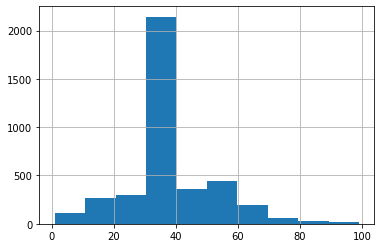

In [438]:
final_dataset['hours-per-week'].hist()

In [439]:
model = Mean_fill(final_dataset, 'hours-per-week')
model.fit()

40.051974522292994

natrenovanie modelu pre doplnenie priemeru hours-per-week

In [440]:
model.transform(final_dataset, 'hours-per-week')

kurtosis_oxygen          occupation          marital-status pregnant  \
0            9.246478     Exec-managerial      Married-civ-spouse        f   
1           22.091694        Adm-clerical           Never-married        f   
2            5.677978     Exec-managerial           Never-married        f   
3            0.214241               Sales           Never-married        f   
4            8.791325   Machine-op-inspct           Never-married        f   
5           10.811388     Exec-managerial      Married-civ-spouse        f   
6           17.160408        Craft_repair                Divorced        f   
7            5.934140        Craft-repair      Married-civ-spouse        f   
8            3.295862      Prof-specialty      Married-civ-spouse        f   
9           11.100580     Exec_managerial      Married-civ-spouse        f   
10           1.475518        Adm-clerical                Divorced        f   
11           8.755388               Sales           Never-married        f   
12           8.509842      Prof-specialty      Married-civ-spouse        f   
13           9.172650    Transport-moving      Married-civ-spouse        f   
14           9.588315        Craft-repair      Married-civ-spouse        f   
15           5.848120               Sales           Never-married        f   
16          10.980253    Transport_moving      Married-civ-spouse        f   
17          12.248611     Exec-managerial                Divorced        f   
18           5.919329       Other-service           Never-married        f   
19           6.610455     Protective-serv      Married-civ-spouse        f   
20          18.157320        Craft-repair               Separated        f   
21          11.629120                   ?      Married-civ-spouse        f   
22           9.522586        Adm-clerical      Married-civ-spouse        f   
23           8.405065     Protective-serv                Divorced        f   
24           7.966258               Sales           Never-married        f   
25           4.408296               Sales      Married-civ-spouse        f   
26           3.918737        Tech-support           Never-married        f   
27           1.123216      Prof-specialty                Divorced        f   
28           3.399783      Prof-specialty                Divorced        f   
29          11.946580        Tech-support           Never-married        f   
...               ...                 ...                     ...      ...   
3903         0.667374                   ?           Never-married        f   
3904        11.022810      Prof-specialty                Divorced        f   
3905         2.042045   Machine-op-inspct   Married-spouse-absent        f   
3906        12.713836      Prof-specialty      Married-civ-spouse        f   
3907         3.938706     Farming-fishing           Never-married        f   
3908         0.766689               Sales           Never-married        f   
3909         7.984052      Prof-specialty      Married-civ-spouse        f   
3910         6.998796        Craft-repair      Married-civ-spouse        f   
3911         7.579058      Prof-specialty                Divorced        f   
3912        11.139194        Craft-repair      Married-civ-spouse        f   
3913         0.923272        Craft-repair      Married-civ-spouse        f   
3914         0.182897        Craft-repair               Separated        f   
3915         1.636346    Transport-moving      Married-civ-spouse        f   
3916         4.305626    Transport-moving           Never-married        f   
3917        11.438551     Exec-managerial           Never-married        f   
3918         5.364287      Prof_specialty           Never-married        f   
3919        12.398981     Farming-fishing                 Widowed        f   
3920         6.625637        Adm-clerical               Separated        f   
3921         9.054940    Transport-moving                Divorced        f   
3922         2.040426       

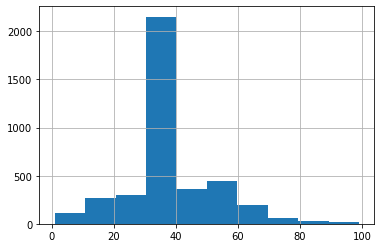

In [441]:
final_dataset['hours-per-week'].hist()

Pouzitie modelu na doplnenie chybajucich hodnot

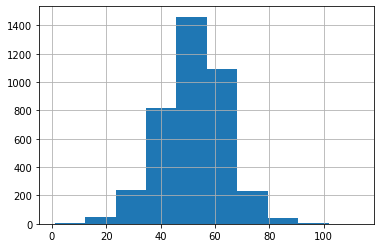

In [442]:
final_dataset['mean_oxygen'].hist()

In [443]:
model = Median_fill(final_dataset, 'mean_oxygen')
model.fit()

52.0

Natrenovanie modelu pre doplnenie medianu 

In [444]:
model.transform(final_dataset, 'mean_oxygen')

kurtosis_oxygen          occupation          marital-status pregnant  \
0            9.246478     Exec-managerial      Married-civ-spouse        f   
1           22.091694        Adm-clerical           Never-married        f   
2            5.677978     Exec-managerial           Never-married        f   
3            0.214241               Sales           Never-married        f   
4            8.791325   Machine-op-inspct           Never-married        f   
5           10.811388     Exec-managerial      Married-civ-spouse        f   
6           17.160408        Craft_repair                Divorced        f   
7            5.934140        Craft-repair      Married-civ-spouse        f   
8            3.295862      Prof-specialty      Married-civ-spouse        f   
9           11.100580     Exec_managerial      Married-civ-spouse        f   
10           1.475518        Adm-clerical                Divorced        f   
11           8.755388               Sales           Never-married        f   
12           8.509842      Prof-specialty      Married-civ-spouse        f   
13           9.172650    Transport-moving      Married-civ-spouse        f   
14           9.588315        Craft-repair      Married-civ-spouse        f   
15           5.848120               Sales           Never-married        f   
16          10.980253    Transport_moving      Married-civ-spouse        f   
17          12.248611     Exec-managerial                Divorced        f   
18           5.919329       Other-service           Never-married        f   
19           6.610455     Protective-serv      Married-civ-spouse        f   
20          18.157320        Craft-repair               Separated        f   
21          11.629120                   ?      Married-civ-spouse        f   
22           9.522586        Adm-clerical      Married-civ-spouse        f   
23           8.405065     Protective-serv                Divorced        f   
24           7.966258               Sales           Never-married        f   
25           4.408296               Sales      Married-civ-spouse        f   
26           3.918737        Tech-support           Never-married        f   
27           1.123216      Prof-specialty                Divorced        f   
28           3.399783      Prof-specialty                Divorced        f   
29          11.946580        Tech-support           Never-married        f   
...               ...                 ...                     ...      ...   
3903         0.667374                   ?           Never-married        f   
3904        11.022810      Prof-specialty                Divorced        f   
3905         2.042045   Machine-op-inspct   Married-spouse-absent        f   
3906        12.713836      Prof-specialty      Married-civ-spouse        f   
3907         3.938706     Farming-fishing           Never-married        f   
3908         0.766689               Sales           Never-married        f   
3909         7.984052      Prof-specialty      Married-civ-spouse        f   
3910         6.998796        Craft-repair      Married-civ-spouse        f   
3911         7.579058      Prof-specialty                Divorced        f   
3912        11.139194        Craft-repair      Married-civ-spouse        f   
3913         0.923272        Craft-repair      Married-civ-spouse        f   
3914         0.182897        Craft-repair               Separated        f   
3915         1.636346    Transport-moving      Married-civ-spouse        f   
3916         4.305626    Transport-moving           Never-married        f   
3917        11.438551     Exec-managerial           Never-married        f   
3918         5.364287      Prof_specialty           Never-married        f   
3919        12.398981     Farming-fishing                 Widowed        f   
3920         6.625637        Adm-clerical               Separated        f   
3921         9.054940    Transport-moving                Divorced        f   
3922         2.040426       

Pouzitie modelu na doplnenie chybajucich hodnot

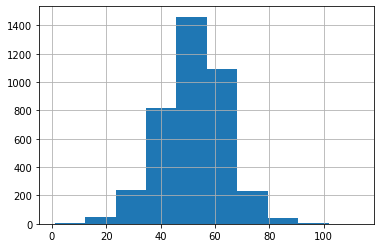

In [445]:
final_dataset['mean_oxygen'].hist()

In [446]:
final_dataset.dtypes

kurtosis_oxygen     float64
occupation           object
marital-status       object
pregnant             object
education-num       float64
relationship         object
std_oxygen          float64
capital-gain        float64
skewness_oxygen     float64
education            object
fnlwgt              float64
class               float64
income               object
native-country       object
capital-loss        float64
mean_oxygen           int64
hours-per-week      float64
race                 object
workclass            object
mean_glucose        float64
std_glucose         float64
kurtosis_glucose    float64
skewness_glucose    float64
age                   int64
sex                  object
dtype: object

In [447]:
final_dataset = setAlpha(final_dataset)

uprava kategorickych atributov(lowercase na vsetky pismena a odstranenie inych ako abecednych znakov)

In [448]:
final_dataset.dtypes

kurtosis_oxygen     float64
occupation           object
marital-status       object
pregnant             object
education-num       float64
relationship         object
std_oxygen          float64
capital-gain        float64
skewness_oxygen     float64
education            object
fnlwgt              float64
class               float64
income               object
native-country       object
capital-loss        float64
mean_oxygen           int64
hours-per-week      float64
race                 object
workclass            object
mean_glucose        float64
std_glucose         float64
kurtosis_glucose    float64
skewness_glucose    float64
age                   int64
sex                  object
dtype: object

In [449]:
final_dataset.head()

kurtosis_oxygen       occupation    marital-status pregnant  education-num  \
0         9.246478   execmanagerial  marriedcivspouse        f           13.0   
1        22.091694      admclerical      nevermarried        f           10.0   
2         5.677978   execmanagerial      nevermarried        f           13.0   
3         0.214241            sales      nevermarried        f            8.0   
4         8.791325  machineopinspct      nevermarried        f            6.0   

    relationship  std_oxygen  capital-gain  skewness_oxygen    education  ...  \
0        husband   14.682571           0.0         4.683409    bachelors  ...   
1  otherrelative    8.827777           0.0         6.378509  somecollege  ...   
2    notinfamily   31.281121        8614.0         3.455192    bachelors  ...   
3    notinfamily   65.506380        4650.0              NaN         12th  ...   
4       ownchild   18.180651           0.0         4.472012         10th  ...   

   mean_oxygen  hours-per-week   race      workclass  mean_glucose  \
0           70            60.0  white        private     79.835938   
1           35            40.0  white        private    117.468750   
2           58            40.0  white        private    109.023438   
3           69            50.0  white        private     16.054688   
4           47            40.0  white  selfempnotinc    110.179688   

   std_glucose  kurtosis_glucose skewness_glucose age     sex  
0    38.732007          0.835317         1.419158  70    male  
1    52.075057          0.041948              NaN  35  female  
2    49.134933          0.322659         0.363231  58    male  
3  3806.004889          4.992568         5.048906  69    male  
4    50.864623          0.480249              NaN  47    male  

[5 rows x 25 columns]

In [450]:
final_dataset.columns

Index(['kurtosis_oxygen', 'occupation', 'marital-status', 'pregnant',
       'education-num', 'relationship', 'std_oxygen', 'capital-gain',
       'skewness_oxygen', 'education', 'fnlwgt', 'class', 'income',
       'native-country', 'capital-loss', 'mean_oxygen', 'hours-per-week',
       'race', 'workclass', 'mean_glucose', 'std_glucose', 'kurtosis_glucose',
       'skewness_glucose', 'age', 'sex'],
      dtype='object')

In [451]:
final_dataset.dtypes

kurtosis_oxygen     float64
occupation           object
marital-status       object
pregnant             object
education-num       float64
relationship         object
std_oxygen          float64
capital-gain        float64
skewness_oxygen     float64
education            object
fnlwgt              float64
class               float64
income               object
native-country       object
capital-loss        float64
mean_oxygen           int64
hours-per-week      float64
race                 object
workclass            object
mean_glucose        float64
std_glucose         float64
kurtosis_glucose    float64
skewness_glucose    float64
age                   int64
sex                  object
dtype: object

In [452]:
model = Quartile(final_dataset, 'hours-per-week')
model.fit()

(16.0, 60.0)

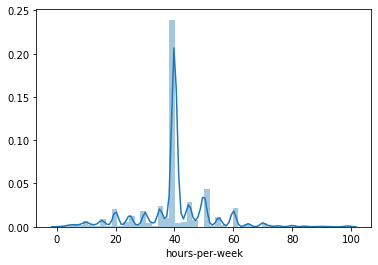

In [453]:
sns.distplot(final_dataset['hours-per-week'])

Natrenovanie modelu na upravenie outlyerov - pouzitie 5% a 95% kvartilu

In [454]:
model.transform(final_dataset, 'hours-per-week')

kurtosis_oxygen        occupation       marital-status pregnant  \
0            9.246478    execmanagerial     marriedcivspouse        f   
1           22.091694       admclerical         nevermarried        f   
2            5.677978    execmanagerial         nevermarried        f   
3            0.214241             sales         nevermarried        f   
4            8.791325   machineopinspct         nevermarried        f   
5           10.811388    execmanagerial     marriedcivspouse        f   
6           17.160408       craftrepair             divorced        f   
7            5.934140       craftrepair     marriedcivspouse        f   
8            3.295862     profspecialty     marriedcivspouse        f   
9           11.100580    execmanagerial     marriedcivspouse        f   
10           1.475518       admclerical             divorced        f   
11           8.755388             sales         nevermarried        f   
12           8.509842     profspecialty     marriedcivspouse        f   
13           9.172650   transportmoving     marriedcivspouse        f   
14           9.588315       craftrepair     marriedcivspouse        f   
15           5.848120             sales         nevermarried        f   
16          10.980253   transportmoving     marriedcivspouse        f   
17          12.248611    execmanagerial             divorced        f   
18           5.919329      otherservice         nevermarried        f   
19           6.610455    protectiveserv     marriedcivspouse        f   
20          18.157320       craftrepair            separated        f   
21          11.629120                       marriedcivspouse        f   
22           9.522586       admclerical     marriedcivspouse        f   
23           8.405065    protectiveserv             divorced        f   
24           7.966258             sales         nevermarried        f   
25           4.408296             sales     marriedcivspouse        f   
26           3.918737       techsupport         nevermarried        f   
27           1.123216     profspecialty             divorced        f   
28           3.399783     profspecialty             divorced        f   
29          11.946580       techsupport         nevermarried        f   
...               ...               ...                  ...      ...   
3903         0.667374                           nevermarried        f   
3904        11.022810     profspecialty             divorced        f   
3905         2.042045   machineopinspct  marriedspouseabsent        f   
3906        12.713836     profspecialty     marriedcivspouse        f   
3907         3.938706    farmingfishing         nevermarried        f   
3908         0.766689             sales         nevermarried        f   
3909         7.984052     profspecialty     marriedcivspouse        f   
3910         6.998796       craftrepair     marriedcivspouse        f   
3911         7.579058     profspecialty             divorced        f   
3912        11.139194       craftrepair     marriedcivspouse        f   
3913         0.923272       craftrepair     marriedcivspouse        f   
3914         0.182897       craftrepair            separated        f   
3915         1.636346   transportmoving     marriedcivspouse        f   
3916         4.305626   transportmoving         nevermarried        f   
3917        11.438551    execmanagerial         nevermarried        f   
3918         5.364287     profspecialty         nevermarried        f   
3919        12.398981    farmingfishing              widowed        f   
3920         6.625637       admclerical            separated        f   
3921         9.054940   transportmoving             divorced        f   
3922         2.040426      otherservice     marriedcivspouse        f   
3923         9.659164             sales         nevermarried        f   
3924         9.501852       craftrepair     marriedcivspouse        f   
3925         7.857542       techsupport         nevermarried    

Odstranenie outlyerov pomocou natrenovaneho modelu

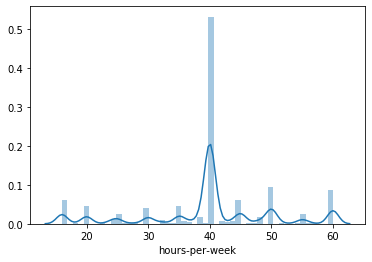

In [455]:
sns.distplot(final_dataset['hours-per-week'])

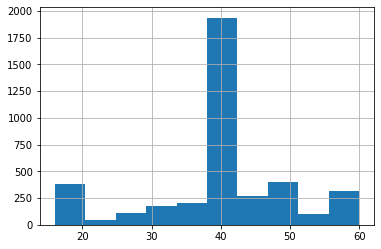

In [456]:
final_dataset['hours-per-week'].hist()

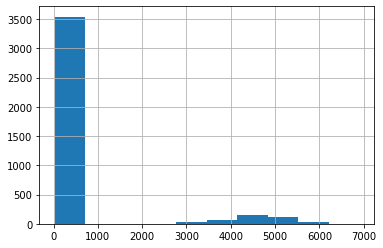

In [457]:
final_dataset['std_glucose'].hist()

In [458]:
final_dataset.std_glucose.describe()

count    3933.000000
mean      495.137250
std      1369.331846
min        25.695250
25%        40.995575
50%        46.775718
75%        52.158691
max      6892.691548
Name: std_glucose, dtype: float64

In [459]:
final_dataset = fix_value_constant(final_dataset,'std_glucose',100,1000)
final_dataset

kurtosis_oxygen        occupation       marital-status pregnant  \
0            9.246478    execmanagerial     marriedcivspouse        f   
1           22.091694       admclerical         nevermarried        f   
2            5.677978    execmanagerial         nevermarried        f   
3            0.214241             sales         nevermarried        f   
4            8.791325   machineopinspct         nevermarried        f   
5           10.811388    execmanagerial     marriedcivspouse        f   
6           17.160408       craftrepair             divorced        f   
7            5.934140       craftrepair     marriedcivspouse        f   
8            3.295862     profspecialty     marriedcivspouse        f   
9           11.100580    execmanagerial     marriedcivspouse        f   
10           1.475518       admclerical             divorced        f   
11           8.755388             sales         nevermarried        f   
12           8.509842     profspecialty     marriedcivspouse        f   
13           9.172650   transportmoving     marriedcivspouse        f   
14           9.588315       craftrepair     marriedcivspouse        f   
15           5.848120             sales         nevermarried        f   
16          10.980253   transportmoving     marriedcivspouse        f   
17          12.248611    execmanagerial             divorced        f   
18           5.919329      otherservice         nevermarried        f   
19           6.610455    protectiveserv     marriedcivspouse        f   
20          18.157320       craftrepair            separated        f   
21          11.629120                       marriedcivspouse        f   
22           9.522586       admclerical     marriedcivspouse        f   
23           8.405065    protectiveserv             divorced        f   
24           7.966258             sales         nevermarried        f   
25           4.408296             sales     marriedcivspouse        f   
26           3.918737       techsupport         nevermarried        f   
27           1.123216     profspecialty             divorced        f   
28           3.399783     profspecialty             divorced        f   
29          11.946580       techsupport         nevermarried        f   
...               ...               ...                  ...      ...   
3903         0.667374                           nevermarried        f   
3904        11.022810     profspecialty             divorced        f   
3905         2.042045   machineopinspct  marriedspouseabsent        f   
3906        12.713836     profspecialty     marriedcivspouse        f   
3907         3.938706    farmingfishing         nevermarried        f   
3908         0.766689             sales         nevermarried        f   
3909         7.984052     profspecialty     marriedcivspouse        f   
3910         6.998796       craftrepair     marriedcivspouse        f   
3911         7.579058     profspecialty             divorced        f   
3912        11.139194       craftrepair     marriedcivspouse        f   
3913         0.923272       craftrepair     marriedcivspouse        f   
3914         0.182897       craftrepair            separated        f   
3915         1.636346   transportmoving     marriedcivspouse        f   
3916         4.305626   transportmoving         nevermarried        f   
3917        11.438551    execmanagerial         nevermarried        f   
3918         5.364287     profspecialty         nevermarried        f   
3919        12.398981    farmingfishing              widowed        f   
3920         6.625637       admclerical            separated        f   
3921         9.054940   transportmoving             divorced        f   
3922         2.040426      otherservice     marriedcivspouse        f   
3923         9.659164             sales         nevermarried        f   
3924         9.501852       craftrepair     marriedcivspouse        f   
3925         7.857542       techsupport         nevermarried    

Pri std_glucose sme si vsimli ze niektore hodnoty su 100x vecsie, preto sme ich predelili konstantov

In [460]:
final_dataset.std_glucose.describe()

count    3933.000000
mean       45.174684
std         7.607881
min        25.695250
25%        40.165726
50%        45.887420
75%        50.369068
max        91.206475
Name: std_glucose, dtype: float64

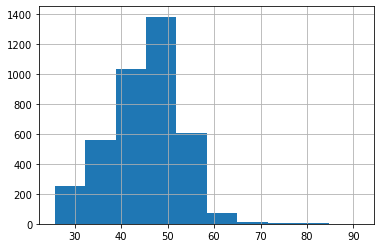

In [461]:
final_dataset['std_glucose'].hist()

/Users/michalkabac/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/michalkabac/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/michalkabac/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/michalkabac/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


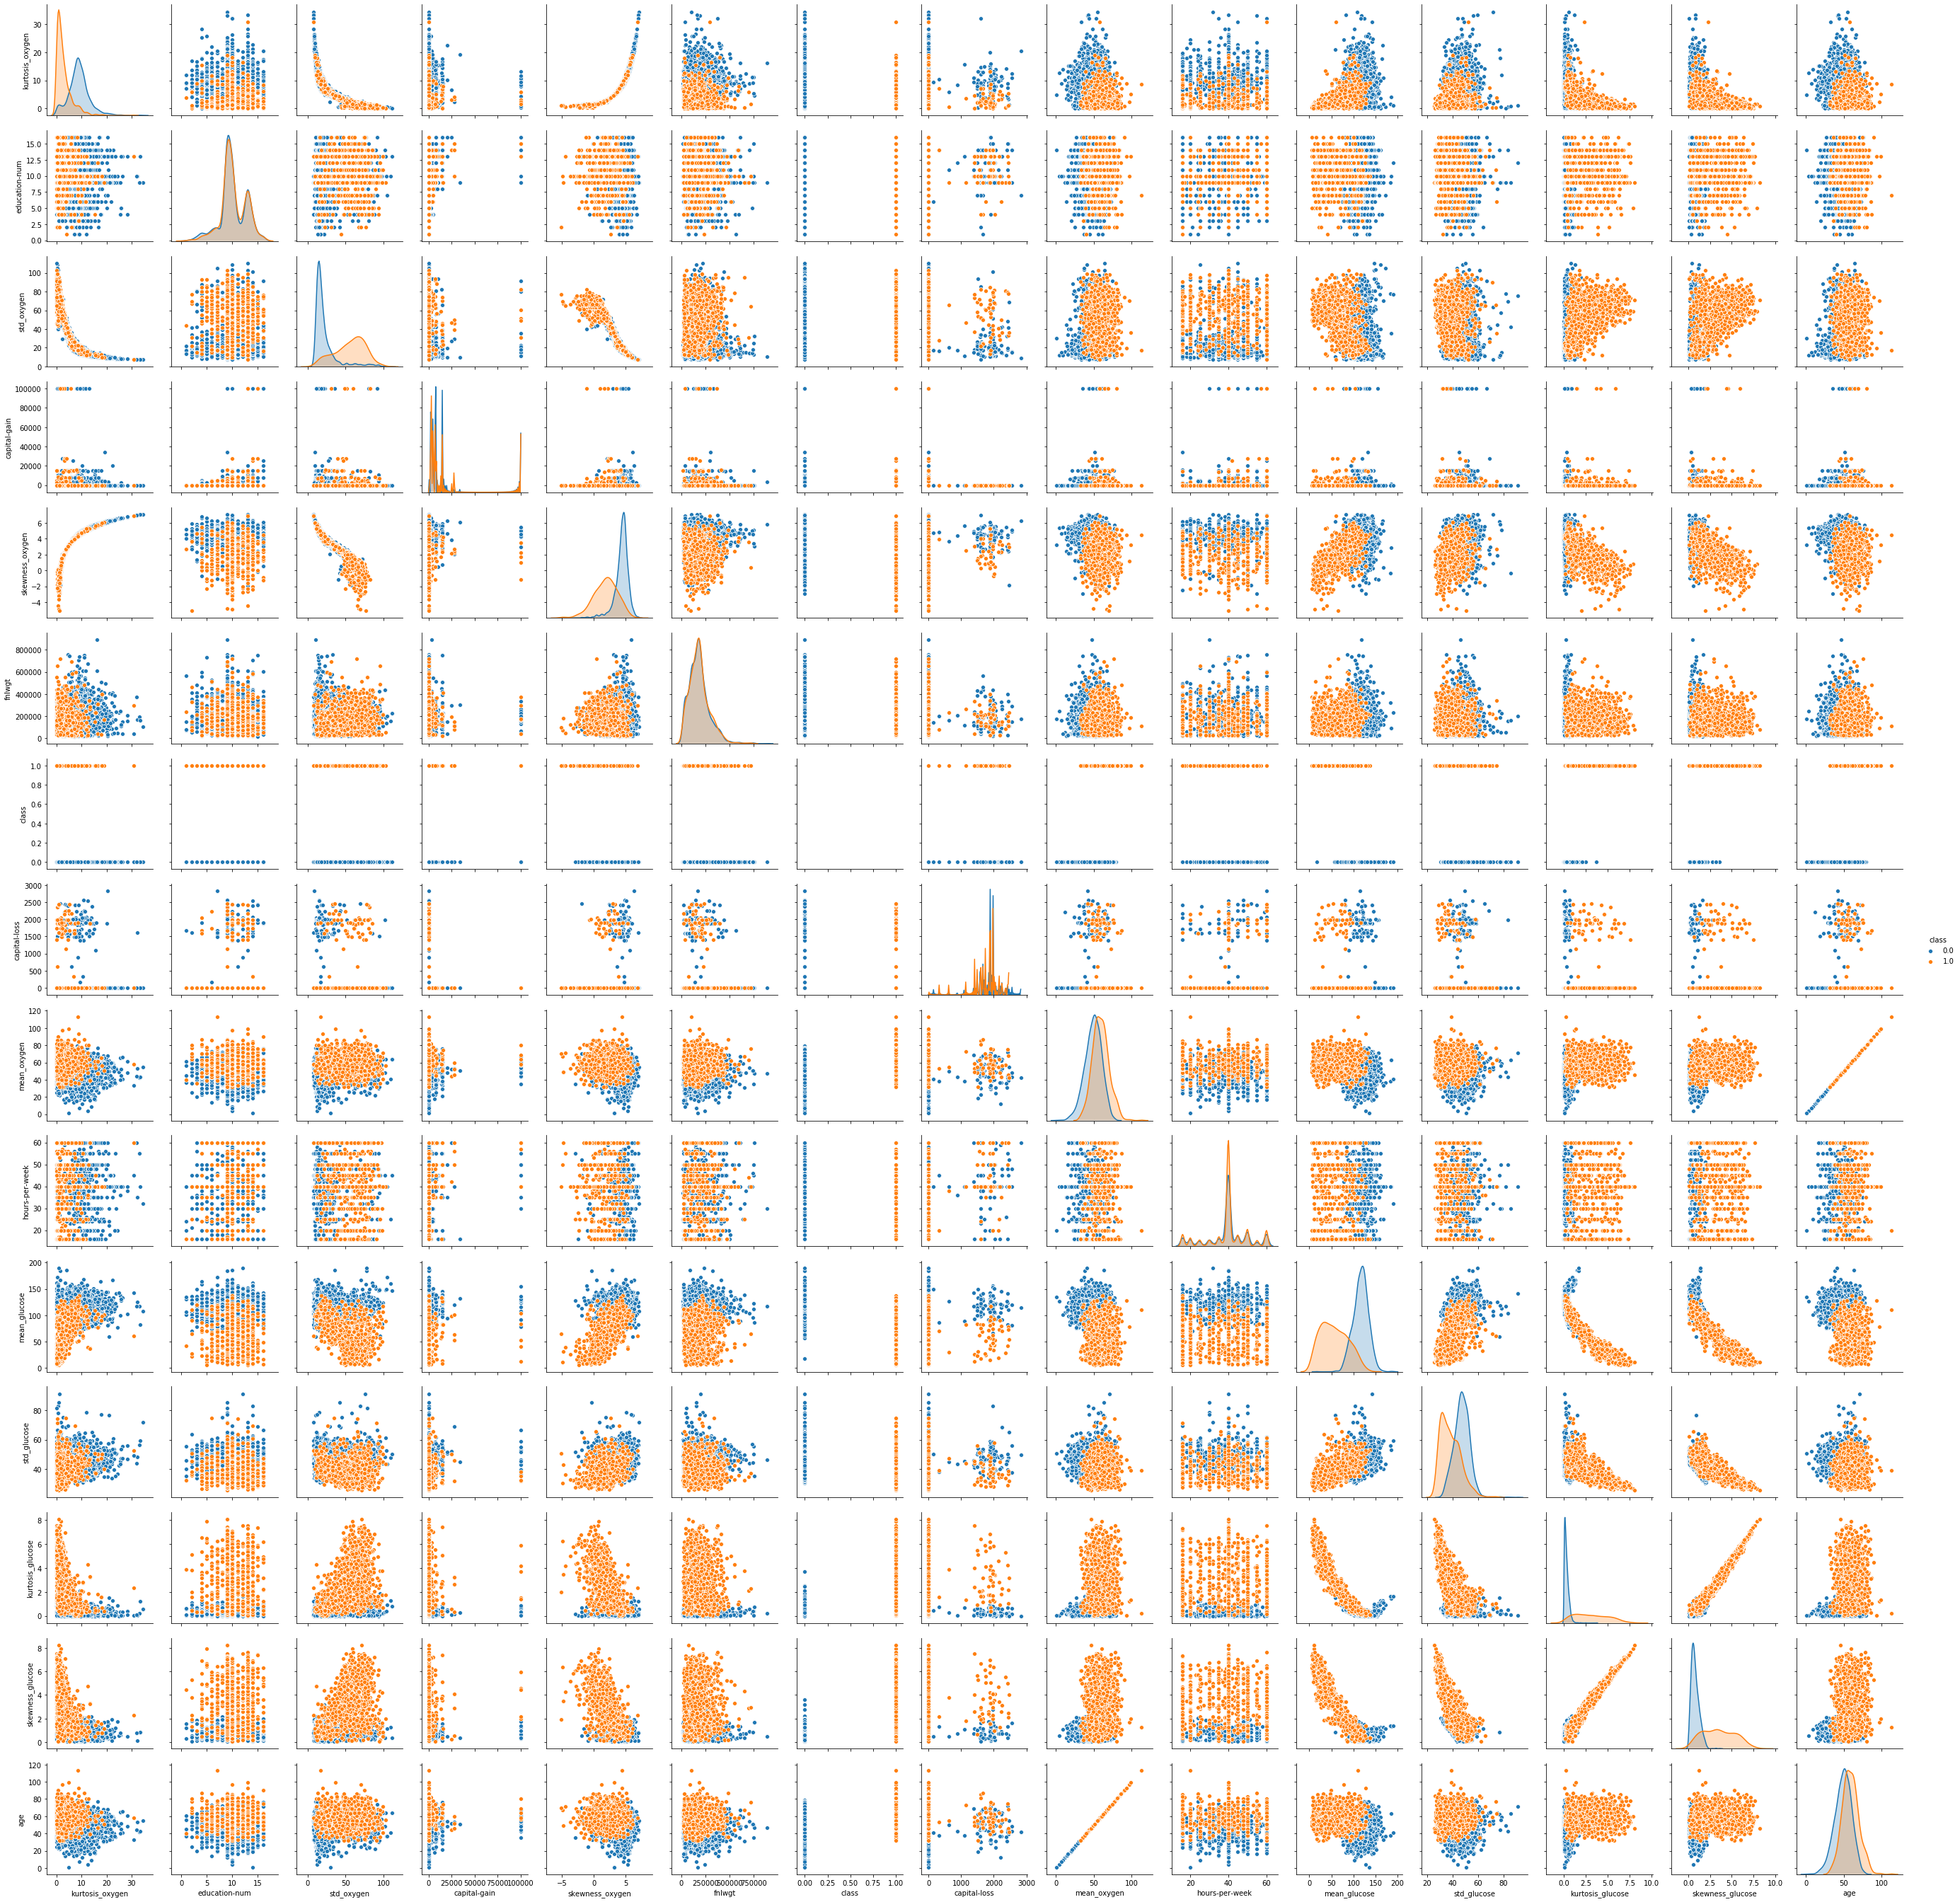

In [462]:
sns.pairplot(final_dataset, hue="class")

Pouzitie pairplotu na vykreslenie grafov, najdenie zaujimavych grafov

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c401f78d0>,
      dtype=object)

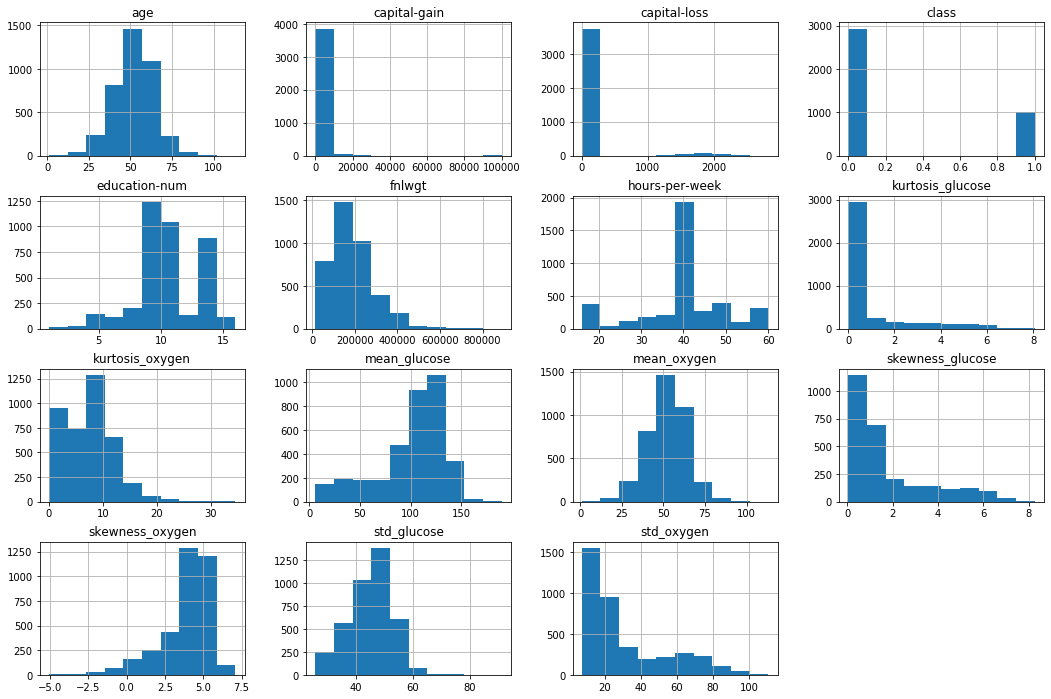

In [463]:
final_dataset.hist(figsize=(18,12))

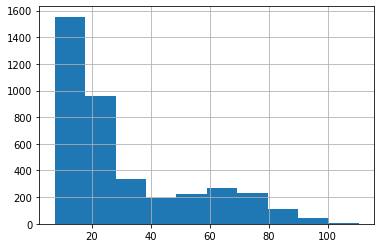

In [464]:
final_dataset['std_oxygen'].hist()

In [465]:
final_dataset = sqrt_normalization(final_dataset,'std_oxygen')

Normalizacia udajov pomocou odmocniny

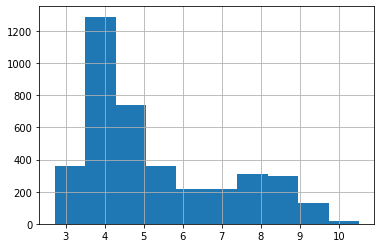

In [466]:
final_dataset['std_oxygen'].hist()

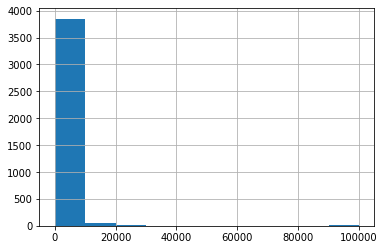

In [467]:
final_dataset['capital-gain'].hist()

In [468]:
model = Quartile(final_dataset, 'capital-gain')
model.fit()

(0.0, 4508.0)

In [469]:
model.transform(final_dataset, 'capital-gain')

kurtosis_oxygen        occupation       marital-status pregnant  \
0            9.246478    execmanagerial     marriedcivspouse        f   
1           22.091694       admclerical         nevermarried        f   
2            5.677978    execmanagerial         nevermarried        f   
3            0.214241             sales         nevermarried        f   
4            8.791325   machineopinspct         nevermarried        f   
5           10.811388    execmanagerial     marriedcivspouse        f   
6           17.160408       craftrepair             divorced        f   
7            5.934140       craftrepair     marriedcivspouse        f   
8            3.295862     profspecialty     marriedcivspouse        f   
9           11.100580    execmanagerial     marriedcivspouse        f   
10           1.475518       admclerical             divorced        f   
11           8.755388             sales         nevermarried        f   
12           8.509842     profspecialty     marriedcivspouse        f   
13           9.172650   transportmoving     marriedcivspouse        f   
14           9.588315       craftrepair     marriedcivspouse        f   
15           5.848120             sales         nevermarried        f   
16          10.980253   transportmoving     marriedcivspouse        f   
17          12.248611    execmanagerial             divorced        f   
18           5.919329      otherservice         nevermarried        f   
19           6.610455    protectiveserv     marriedcivspouse        f   
20          18.157320       craftrepair            separated        f   
21          11.629120                       marriedcivspouse        f   
22           9.522586       admclerical     marriedcivspouse        f   
23           8.405065    protectiveserv             divorced        f   
24           7.966258             sales         nevermarried        f   
25           4.408296             sales     marriedcivspouse        f   
26           3.918737       techsupport         nevermarried        f   
27           1.123216     profspecialty             divorced        f   
28           3.399783     profspecialty             divorced        f   
29          11.946580       techsupport         nevermarried        f   
...               ...               ...                  ...      ...   
3903         0.667374                           nevermarried        f   
3904        11.022810     profspecialty             divorced        f   
3905         2.042045   machineopinspct  marriedspouseabsent        f   
3906        12.713836     profspecialty     marriedcivspouse        f   
3907         3.938706    farmingfishing         nevermarried        f   
3908         0.766689             sales         nevermarried        f   
3909         7.984052     profspecialty     marriedcivspouse        f   
3910         6.998796       craftrepair     marriedcivspouse        f   
3911         7.579058     profspecialty             divorced        f   
3912        11.139194       craftrepair     marriedcivspouse        f   
3913         0.923272       craftrepair     marriedcivspouse        f   
3914         0.182897       craftrepair            separated        f   
3915         1.636346   transportmoving     marriedcivspouse        f   
3916         4.305626   transportmoving         nevermarried        f   
3917        11.438551    execmanagerial         nevermarried        f   
3918         5.364287     profspecialty         nevermarried        f   
3919        12.398981    farmingfishing              widowed        f   
3920         6.625637       admclerical            separated        f   
3921         9.054940   transportmoving             divorced        f   
3922         2.040426      otherservice     marriedcivspouse        f   
3923         9.659164             sales         nevermarried        f   
3924         9.501852       craftrepair     marriedcivspouse        f   
3925         7.857542       techsupport         nevermarried    

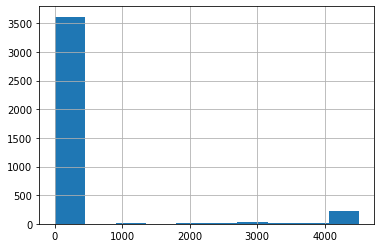

In [470]:
final_dataset['capital-gain'].hist()

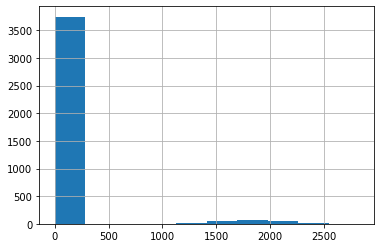

In [471]:
final_dataset['capital-loss'].hist()

In [472]:
model = Quartile(final_dataset, 'capital-loss')
model.fit()

(0.0, 0.0)

kedze vidime ze 5% aj 95% kvartil je 0 tak v tomto pripade nebudeme hodnoty nahradzovat

Tento stlpec sme nakoniec nenormalizovali

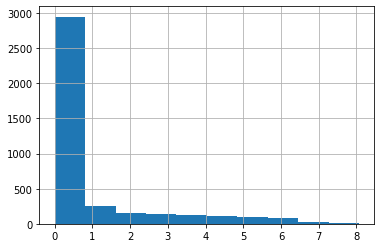

In [473]:
final_dataset['kurtosis_glucose'].hist()

Kurtosis glucose nakolko sa jedna o longtail rozdelenie podla mna dane rozdelenie netreba upravovat

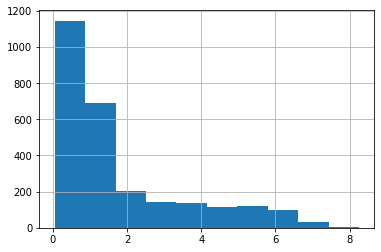

In [474]:
final_dataset['skewness_glucose'].hist()

Toto rozdelenie je taktiez long tail takze dalej ho neplanujem upravovat

Pozrime sa ako teraz vyzeraju vsetky rozdelenia

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c438d77b8>,
      dtype=object)

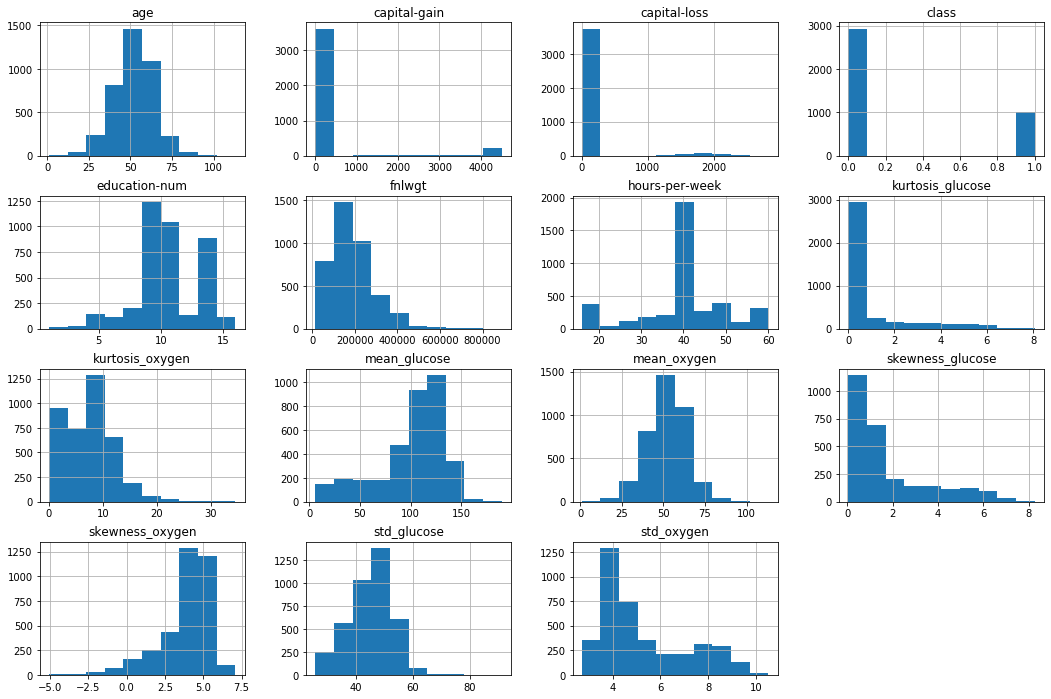

In [475]:
final_dataset.hist(figsize=(18,12))

Rozdelenia uz vyzeraju v pohode

## Nahradzanie chybajucich hodnot

In [477]:
final_dataset.columns

Index(['kurtosis_oxygen', 'occupation', 'marital-status', 'pregnant',
       'education-num', 'relationship', 'std_oxygen', 'capital-gain',
       'skewness_oxygen', 'education', 'fnlwgt', 'class', 'income',
       'native-country', 'capital-loss', 'mean_oxygen', 'hours-per-week',
       'race', 'workclass', 'mean_glucose', 'std_glucose', 'kurtosis_glucose',
       'skewness_glucose', 'age', 'sex'],
      dtype='object')

In [479]:
model = Mode_fill(final_dataset,'race')
model.fit()

0    white
dtype: object

In [480]:
model.transform(final_dataset, 'race')

kurtosis_oxygen        occupation       marital-status pregnant  \
0            9.246478    execmanagerial     marriedcivspouse        f   
1           22.091694       admclerical         nevermarried        f   
2            5.677978    execmanagerial         nevermarried        f   
3            0.214241             sales         nevermarried        f   
4            8.791325   machineopinspct         nevermarried        f   
5           10.811388    execmanagerial     marriedcivspouse        f   
6           17.160408       craftrepair             divorced        f   
7            5.934140       craftrepair     marriedcivspouse        f   
8            3.295862     profspecialty     marriedcivspouse        f   
9           11.100580    execmanagerial     marriedcivspouse        f   
10           1.475518       admclerical             divorced        f   
11           8.755388             sales         nevermarried        f   
12           8.509842     profspecialty     marriedcivspouse        f   
13           9.172650   transportmoving     marriedcivspouse        f   
14           9.588315       craftrepair     marriedcivspouse        f   
15           5.848120             sales         nevermarried        f   
16          10.980253   transportmoving     marriedcivspouse        f   
17          12.248611    execmanagerial             divorced        f   
18           5.919329      otherservice         nevermarried        f   
19           6.610455    protectiveserv     marriedcivspouse        f   
20          18.157320       craftrepair            separated        f   
21          11.629120                       marriedcivspouse        f   
22           9.522586       admclerical     marriedcivspouse        f   
23           8.405065    protectiveserv             divorced        f   
24           7.966258             sales         nevermarried        f   
25           4.408296             sales     marriedcivspouse        f   
26           3.918737       techsupport         nevermarried        f   
27           1.123216     profspecialty             divorced        f   
28           3.399783     profspecialty             divorced        f   
29          11.946580       techsupport         nevermarried        f   
...               ...               ...                  ...      ...   
3903         0.667374                           nevermarried        f   
3904        11.022810     profspecialty             divorced        f   
3905         2.042045   machineopinspct  marriedspouseabsent        f   
3906        12.713836     profspecialty     marriedcivspouse        f   
3907         3.938706    farmingfishing         nevermarried        f   
3908         0.766689             sales         nevermarried        f   
3909         7.984052     profspecialty     marriedcivspouse        f   
3910         6.998796       craftrepair     marriedcivspouse        f   
3911         7.579058     profspecialty             divorced        f   
3912        11.139194       craftrepair     marriedcivspouse        f   
3913         0.923272       craftrepair     marriedcivspouse        f   
3914         0.182897       craftrepair            separated        f   
3915         1.636346   transportmoving     marriedcivspouse        f   
3916         4.305626   transportmoving         nevermarried        f   
3917        11.438551    execmanagerial         nevermarried        f   
3918         5.364287     profspecialty         nevermarried        f   
3919        12.398981    farmingfishing              widowed        f   
3920         6.625637       admclerical            separated        f   
3921         9.054940   transportmoving             divorced        f   
3922         2.040426      otherservice     marriedcivspouse        f   
3923         9.659164             sales         nevermarried        f   
3924         9.501852       craftrepair     marriedcivspouse        f   
3925         7.857542       techsupport         nevermarried    

In [481]:
model = Mode_fill(final_dataset,'education')
model.fit()

0    hsgrad
dtype: object

In [482]:
model.transform(final_dataset, 'education')

kurtosis_oxygen        occupation       marital-status pregnant  \
0            9.246478    execmanagerial     marriedcivspouse        f   
1           22.091694       admclerical         nevermarried        f   
2            5.677978    execmanagerial         nevermarried        f   
3            0.214241             sales         nevermarried        f   
4            8.791325   machineopinspct         nevermarried        f   
5           10.811388    execmanagerial     marriedcivspouse        f   
6           17.160408       craftrepair             divorced        f   
7            5.934140       craftrepair     marriedcivspouse        f   
8            3.295862     profspecialty     marriedcivspouse        f   
9           11.100580    execmanagerial     marriedcivspouse        f   
10           1.475518       admclerical             divorced        f   
11           8.755388             sales         nevermarried        f   
12           8.509842     profspecialty     marriedcivspouse        f   
13           9.172650   transportmoving     marriedcivspouse        f   
14           9.588315       craftrepair     marriedcivspouse        f   
15           5.848120             sales         nevermarried        f   
16          10.980253   transportmoving     marriedcivspouse        f   
17          12.248611    execmanagerial             divorced        f   
18           5.919329      otherservice         nevermarried        f   
19           6.610455    protectiveserv     marriedcivspouse        f   
20          18.157320       craftrepair            separated        f   
21          11.629120                       marriedcivspouse        f   
22           9.522586       admclerical     marriedcivspouse        f   
23           8.405065    protectiveserv             divorced        f   
24           7.966258             sales         nevermarried        f   
25           4.408296             sales     marriedcivspouse        f   
26           3.918737       techsupport         nevermarried        f   
27           1.123216     profspecialty             divorced        f   
28           3.399783     profspecialty             divorced        f   
29          11.946580       techsupport         nevermarried        f   
...               ...               ...                  ...      ...   
3903         0.667374                           nevermarried        f   
3904        11.022810     profspecialty             divorced        f   
3905         2.042045   machineopinspct  marriedspouseabsent        f   
3906        12.713836     profspecialty     marriedcivspouse        f   
3907         3.938706    farmingfishing         nevermarried        f   
3908         0.766689             sales         nevermarried        f   
3909         7.984052     profspecialty     marriedcivspouse        f   
3910         6.998796       craftrepair     marriedcivspouse        f   
3911         7.579058     profspecialty             divorced        f   
3912        11.139194       craftrepair     marriedcivspouse        f   
3913         0.923272       craftrepair     marriedcivspouse        f   
3914         0.182897       craftrepair            separated        f   
3915         1.636346   transportmoving     marriedcivspouse        f   
3916         4.305626   transportmoving         nevermarried        f   
3917        11.438551    execmanagerial         nevermarried        f   
3918         5.364287     profspecialty         nevermarried        f   
3919        12.398981    farmingfishing              widowed        f   
3920         6.625637       admclerical            separated        f   
3921         9.054940   transportmoving             divorced        f   
3922         2.040426      otherservice     marriedcivspouse        f   
3923         9.659164             sales         nevermarried        f   
3924         9.501852       craftrepair     marriedcivspouse        f   
3925         7.857542       techsupport         nevermarried    

In [484]:
model = Median_fill(final_dataset,'skewness_glucose')
model.fit()

1.0374936616673858

In [485]:
model.transform(final_dataset, 'skewness_glucose')

kurtosis_oxygen        occupation       marital-status pregnant  \
0            9.246478    execmanagerial     marriedcivspouse        f   
1           22.091694       admclerical         nevermarried        f   
2            5.677978    execmanagerial         nevermarried        f   
3            0.214241             sales         nevermarried        f   
4            8.791325   machineopinspct         nevermarried        f   
5           10.811388    execmanagerial     marriedcivspouse        f   
6           17.160408       craftrepair             divorced        f   
7            5.934140       craftrepair     marriedcivspouse        f   
8            3.295862     profspecialty     marriedcivspouse        f   
9           11.100580    execmanagerial     marriedcivspouse        f   
10           1.475518       admclerical             divorced        f   
11           8.755388             sales         nevermarried        f   
12           8.509842     profspecialty     marriedcivspouse        f   
13           9.172650   transportmoving     marriedcivspouse        f   
14           9.588315       craftrepair     marriedcivspouse        f   
15           5.848120             sales         nevermarried        f   
16          10.980253   transportmoving     marriedcivspouse        f   
17          12.248611    execmanagerial             divorced        f   
18           5.919329      otherservice         nevermarried        f   
19           6.610455    protectiveserv     marriedcivspouse        f   
20          18.157320       craftrepair            separated        f   
21          11.629120                       marriedcivspouse        f   
22           9.522586       admclerical     marriedcivspouse        f   
23           8.405065    protectiveserv             divorced        f   
24           7.966258             sales         nevermarried        f   
25           4.408296             sales     marriedcivspouse        f   
26           3.918737       techsupport         nevermarried        f   
27           1.123216     profspecialty             divorced        f   
28           3.399783     profspecialty             divorced        f   
29          11.946580       techsupport         nevermarried        f   
...               ...               ...                  ...      ...   
3903         0.667374                           nevermarried        f   
3904        11.022810     profspecialty             divorced        f   
3905         2.042045   machineopinspct  marriedspouseabsent        f   
3906        12.713836     profspecialty     marriedcivspouse        f   
3907         3.938706    farmingfishing         nevermarried        f   
3908         0.766689             sales         nevermarried        f   
3909         7.984052     profspecialty     marriedcivspouse        f   
3910         6.998796       craftrepair     marriedcivspouse        f   
3911         7.579058     profspecialty             divorced        f   
3912        11.139194       craftrepair     marriedcivspouse        f   
3913         0.923272       craftrepair     marriedcivspouse        f   
3914         0.182897       craftrepair            separated        f   
3915         1.636346   transportmoving     marriedcivspouse        f   
3916         4.305626   transportmoving         nevermarried        f   
3917        11.438551    execmanagerial         nevermarried        f   
3918         5.364287     profspecialty         nevermarried        f   
3919        12.398981    farmingfishing              widowed        f   
3920         6.625637       admclerical            separated        f   
3921         9.054940   transportmoving             divorced        f   
3922         2.040426      otherservice     marriedcivspouse        f   
3923         9.659164             sales         nevermarried        f   
3924         9.501852       craftrepair     marriedcivspouse        f   
3925         7.857542       techsupport         nevermarried    

In [486]:
clf = fit_minmax(final_dataset, 'capital-loss')

In [487]:
final_dataset = transform_minmax(final_dataset, 'capital-loss',clf)

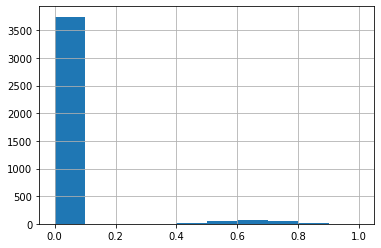

In [488]:
final_dataset['capital-loss'].hist()

Zobrazenie distribucie pomocou histogramov

In [489]:
model = Mode_fill(final_dataset, 'workclass')
model.fit()
model.transform(final_dataset, 'workclass')

kurtosis_oxygen        occupation       marital-status pregnant  \
0            9.246478    execmanagerial     marriedcivspouse        f   
1           22.091694       admclerical         nevermarried        f   
2            5.677978    execmanagerial         nevermarried        f   
3            0.214241             sales         nevermarried        f   
4            8.791325   machineopinspct         nevermarried        f   
5           10.811388    execmanagerial     marriedcivspouse        f   
6           17.160408       craftrepair             divorced        f   
7            5.934140       craftrepair     marriedcivspouse        f   
8            3.295862     profspecialty     marriedcivspouse        f   
9           11.100580    execmanagerial     marriedcivspouse        f   
10           1.475518       admclerical             divorced        f   
11           8.755388             sales         nevermarried        f   
12           8.509842     profspecialty     marriedcivspouse        f   
13           9.172650   transportmoving     marriedcivspouse        f   
14           9.588315       craftrepair     marriedcivspouse        f   
15           5.848120             sales         nevermarried        f   
16          10.980253   transportmoving     marriedcivspouse        f   
17          12.248611    execmanagerial             divorced        f   
18           5.919329      otherservice         nevermarried        f   
19           6.610455    protectiveserv     marriedcivspouse        f   
20          18.157320       craftrepair            separated        f   
21          11.629120                       marriedcivspouse        f   
22           9.522586       admclerical     marriedcivspouse        f   
23           8.405065    protectiveserv             divorced        f   
24           7.966258             sales         nevermarried        f   
25           4.408296             sales     marriedcivspouse        f   
26           3.918737       techsupport         nevermarried        f   
27           1.123216     profspecialty             divorced        f   
28           3.399783     profspecialty             divorced        f   
29          11.946580       techsupport         nevermarried        f   
...               ...               ...                  ...      ...   
3903         0.667374                           nevermarried        f   
3904        11.022810     profspecialty             divorced        f   
3905         2.042045   machineopinspct  marriedspouseabsent        f   
3906        12.713836     profspecialty     marriedcivspouse        f   
3907         3.938706    farmingfishing         nevermarried        f   
3908         0.766689             sales         nevermarried        f   
3909         7.984052     profspecialty     marriedcivspouse        f   
3910         6.998796       craftrepair     marriedcivspouse        f   
3911         7.579058     profspecialty             divorced        f   
3912        11.139194       craftrepair     marriedcivspouse        f   
3913         0.923272       craftrepair     marriedcivspouse        f   
3914         0.182897       craftrepair            separated        f   
3915         1.636346   transportmoving     marriedcivspouse        f   
3916         4.305626   transportmoving         nevermarried        f   
3917        11.438551    execmanagerial         nevermarried        f   
3918         5.364287     profspecialty         nevermarried        f   
3919        12.398981    farmingfishing              widowed        f   
3920         6.625637       admclerical            separated        f   
3921         9.054940   transportmoving             divorced        f   
3922         2.040426      otherservice     marriedcivspouse        f   
3923         9.659164             sales         nevermarried        f   
3924         9.501852       craftrepair     marriedcivspouse        f   
3925         7.857542       techsupport         nevermarried    

Doplnanie hodnot najcastejsie sa vyskytujucim prvkom

In [490]:
model = Mode_fill(final_dataset, 'native-country')
model.fit()
model.transform(final_dataset, 'native-country')

kurtosis_oxygen        occupation       marital-status pregnant  \
0            9.246478    execmanagerial     marriedcivspouse        f   
1           22.091694       admclerical         nevermarried        f   
2            5.677978    execmanagerial         nevermarried        f   
3            0.214241             sales         nevermarried        f   
4            8.791325   machineopinspct         nevermarried        f   
5           10.811388    execmanagerial     marriedcivspouse        f   
6           17.160408       craftrepair             divorced        f   
7            5.934140       craftrepair     marriedcivspouse        f   
8            3.295862     profspecialty     marriedcivspouse        f   
9           11.100580    execmanagerial     marriedcivspouse        f   
10           1.475518       admclerical             divorced        f   
11           8.755388             sales         nevermarried        f   
12           8.509842     profspecialty     marriedcivspouse        f   
13           9.172650   transportmoving     marriedcivspouse        f   
14           9.588315       craftrepair     marriedcivspouse        f   
15           5.848120             sales         nevermarried        f   
16          10.980253   transportmoving     marriedcivspouse        f   
17          12.248611    execmanagerial             divorced        f   
18           5.919329      otherservice         nevermarried        f   
19           6.610455    protectiveserv     marriedcivspouse        f   
20          18.157320       craftrepair            separated        f   
21          11.629120                       marriedcivspouse        f   
22           9.522586       admclerical     marriedcivspouse        f   
23           8.405065    protectiveserv             divorced        f   
24           7.966258             sales         nevermarried        f   
25           4.408296             sales     marriedcivspouse        f   
26           3.918737       techsupport         nevermarried        f   
27           1.123216     profspecialty             divorced        f   
28           3.399783     profspecialty             divorced        f   
29          11.946580       techsupport         nevermarried        f   
...               ...               ...                  ...      ...   
3903         0.667374                           nevermarried        f   
3904        11.022810     profspecialty             divorced        f   
3905         2.042045   machineopinspct  marriedspouseabsent        f   
3906        12.713836     profspecialty     marriedcivspouse        f   
3907         3.938706    farmingfishing         nevermarried        f   
3908         0.766689             sales         nevermarried        f   
3909         7.984052     profspecialty     marriedcivspouse        f   
3910         6.998796       craftrepair     marriedcivspouse        f   
3911         7.579058     profspecialty             divorced        f   
3912        11.139194       craftrepair     marriedcivspouse        f   
3913         0.923272       craftrepair     marriedcivspouse        f   
3914         0.182897       craftrepair            separated        f   
3915         1.636346   transportmoving     marriedcivspouse        f   
3916         4.305626   transportmoving         nevermarried        f   
3917        11.438551    execmanagerial         nevermarried        f   
3918         5.364287     profspecialty         nevermarried        f   
3919        12.398981    farmingfishing              widowed        f   
3920         6.625637       admclerical            separated        f   
3921         9.054940   transportmoving             divorced        f   
3922         2.040426      otherservice     marriedcivspouse        f   
3923         9.659164             sales         nevermarried        f   
3924         9.501852       craftrepair     marriedcivspouse        f   
3925         7.857542       techsupport         nevermarried    

In [491]:
model = Mode_fill(final_dataset, 'income')
model.fit()
model.transform(final_dataset, 'income')

kurtosis_oxygen        occupation       marital-status pregnant  \
0            9.246478    execmanagerial     marriedcivspouse        f   
1           22.091694       admclerical         nevermarried        f   
2            5.677978    execmanagerial         nevermarried        f   
3            0.214241             sales         nevermarried        f   
4            8.791325   machineopinspct         nevermarried        f   
5           10.811388    execmanagerial     marriedcivspouse        f   
6           17.160408       craftrepair             divorced        f   
7            5.934140       craftrepair     marriedcivspouse        f   
8            3.295862     profspecialty     marriedcivspouse        f   
9           11.100580    execmanagerial     marriedcivspouse        f   
10           1.475518       admclerical             divorced        f   
11           8.755388             sales         nevermarried        f   
12           8.509842     profspecialty     marriedcivspouse        f   
13           9.172650   transportmoving     marriedcivspouse        f   
14           9.588315       craftrepair     marriedcivspouse        f   
15           5.848120             sales         nevermarried        f   
16          10.980253   transportmoving     marriedcivspouse        f   
17          12.248611    execmanagerial             divorced        f   
18           5.919329      otherservice         nevermarried        f   
19           6.610455    protectiveserv     marriedcivspouse        f   
20          18.157320       craftrepair            separated        f   
21          11.629120                       marriedcivspouse        f   
22           9.522586       admclerical     marriedcivspouse        f   
23           8.405065    protectiveserv             divorced        f   
24           7.966258             sales         nevermarried        f   
25           4.408296             sales     marriedcivspouse        f   
26           3.918737       techsupport         nevermarried        f   
27           1.123216     profspecialty             divorced        f   
28           3.399783     profspecialty             divorced        f   
29          11.946580       techsupport         nevermarried        f   
...               ...               ...                  ...      ...   
3903         0.667374                           nevermarried        f   
3904        11.022810     profspecialty             divorced        f   
3905         2.042045   machineopinspct  marriedspouseabsent        f   
3906        12.713836     profspecialty     marriedcivspouse        f   
3907         3.938706    farmingfishing         nevermarried        f   
3908         0.766689             sales         nevermarried        f   
3909         7.984052     profspecialty     marriedcivspouse        f   
3910         6.998796       craftrepair     marriedcivspouse        f   
3911         7.579058     profspecialty             divorced        f   
3912        11.139194       craftrepair     marriedcivspouse        f   
3913         0.923272       craftrepair     marriedcivspouse        f   
3914         0.182897       craftrepair            separated        f   
3915         1.636346   transportmoving     marriedcivspouse        f   
3916         4.305626   transportmoving         nevermarried        f   
3917        11.438551    execmanagerial         nevermarried        f   
3918         5.364287     profspecialty         nevermarried        f   
3919        12.398981    farmingfishing              widowed        f   
3920         6.625637       admclerical            separated        f   
3921         9.054940   transportmoving             divorced        f   
3922         2.040426      otherservice     marriedcivspouse        f   
3923         9.659164             sales         nevermarried        f   
3924         9.501852       craftrepair     marriedcivspouse        f   
3925         7.857542       techsupport         nevermarried    

In [492]:
model = Mode_fill(final_dataset, 'pregnant')
model.fit()
model.transform(final_dataset, 'pregnant')

kurtosis_oxygen        occupation       marital-status pregnant  \
0            9.246478    execmanagerial     marriedcivspouse        f   
1           22.091694       admclerical         nevermarried        f   
2            5.677978    execmanagerial         nevermarried        f   
3            0.214241             sales         nevermarried        f   
4            8.791325   machineopinspct         nevermarried        f   
5           10.811388    execmanagerial     marriedcivspouse        f   
6           17.160408       craftrepair             divorced        f   
7            5.934140       craftrepair     marriedcivspouse        f   
8            3.295862     profspecialty     marriedcivspouse        f   
9           11.100580    execmanagerial     marriedcivspouse        f   
10           1.475518       admclerical             divorced        f   
11           8.755388             sales         nevermarried        f   
12           8.509842     profspecialty     marriedcivspouse        f   
13           9.172650   transportmoving     marriedcivspouse        f   
14           9.588315       craftrepair     marriedcivspouse        f   
15           5.848120             sales         nevermarried        f   
16          10.980253   transportmoving     marriedcivspouse        f   
17          12.248611    execmanagerial             divorced        f   
18           5.919329      otherservice         nevermarried        f   
19           6.610455    protectiveserv     marriedcivspouse        f   
20          18.157320       craftrepair            separated        f   
21          11.629120                       marriedcivspouse        f   
22           9.522586       admclerical     marriedcivspouse        f   
23           8.405065    protectiveserv             divorced        f   
24           7.966258             sales         nevermarried        f   
25           4.408296             sales     marriedcivspouse        f   
26           3.918737       techsupport         nevermarried        f   
27           1.123216     profspecialty             divorced        f   
28           3.399783     profspecialty             divorced        f   
29          11.946580       techsupport         nevermarried        f   
...               ...               ...                  ...      ...   
3903         0.667374                           nevermarried        f   
3904        11.022810     profspecialty             divorced        f   
3905         2.042045   machineopinspct  marriedspouseabsent        f   
3906        12.713836     profspecialty     marriedcivspouse        f   
3907         3.938706    farmingfishing         nevermarried        f   
3908         0.766689             sales         nevermarried        f   
3909         7.984052     profspecialty     marriedcivspouse        f   
3910         6.998796       craftrepair     marriedcivspouse        f   
3911         7.579058     profspecialty             divorced        f   
3912        11.139194       craftrepair     marriedcivspouse        f   
3913         0.923272       craftrepair     marriedcivspouse        f   
3914         0.182897       craftrepair            separated        f   
3915         1.636346   transportmoving     marriedcivspouse        f   
3916         4.305626   transportmoving         nevermarried        f   
3917        11.438551    execmanagerial         nevermarried        f   
3918         5.364287     profspecialty         nevermarried        f   
3919        12.398981    farmingfishing              widowed        f   
3920         6.625637       admclerical            separated        f   
3921         9.054940   transportmoving             divorced        f   
3922         2.040426      otherservice     marriedcivspouse        f   
3923         9.659164             sales         nevermarried        f   
3924         9.501852       craftrepair     marriedcivspouse        f   
3925         7.857542       techsupport         nevermarried    

In [493]:
model = Mode_fill(final_dataset, 'marital-status')
model.fit()
model.transform(final_dataset, 'marital-status')

kurtosis_oxygen        occupation       marital-status pregnant  \
0            9.246478    execmanagerial     marriedcivspouse        f   
1           22.091694       admclerical         nevermarried        f   
2            5.677978    execmanagerial         nevermarried        f   
3            0.214241             sales         nevermarried        f   
4            8.791325   machineopinspct         nevermarried        f   
5           10.811388    execmanagerial     marriedcivspouse        f   
6           17.160408       craftrepair             divorced        f   
7            5.934140       craftrepair     marriedcivspouse        f   
8            3.295862     profspecialty     marriedcivspouse        f   
9           11.100580    execmanagerial     marriedcivspouse        f   
10           1.475518       admclerical             divorced        f   
11           8.755388             sales         nevermarried        f   
12           8.509842     profspecialty     marriedcivspouse        f   
13           9.172650   transportmoving     marriedcivspouse        f   
14           9.588315       craftrepair     marriedcivspouse        f   
15           5.848120             sales         nevermarried        f   
16          10.980253   transportmoving     marriedcivspouse        f   
17          12.248611    execmanagerial             divorced        f   
18           5.919329      otherservice         nevermarried        f   
19           6.610455    protectiveserv     marriedcivspouse        f   
20          18.157320       craftrepair            separated        f   
21          11.629120                       marriedcivspouse        f   
22           9.522586       admclerical     marriedcivspouse        f   
23           8.405065    protectiveserv             divorced        f   
24           7.966258             sales         nevermarried        f   
25           4.408296             sales     marriedcivspouse        f   
26           3.918737       techsupport         nevermarried        f   
27           1.123216     profspecialty             divorced        f   
28           3.399783     profspecialty             divorced        f   
29          11.946580       techsupport         nevermarried        f   
...               ...               ...                  ...      ...   
3903         0.667374                           nevermarried        f   
3904        11.022810     profspecialty             divorced        f   
3905         2.042045   machineopinspct  marriedspouseabsent        f   
3906        12.713836     profspecialty     marriedcivspouse        f   
3907         3.938706    farmingfishing         nevermarried        f   
3908         0.766689             sales         nevermarried        f   
3909         7.984052     profspecialty     marriedcivspouse        f   
3910         6.998796       craftrepair     marriedcivspouse        f   
3911         7.579058     profspecialty             divorced        f   
3912        11.139194       craftrepair     marriedcivspouse        f   
3913         0.923272       craftrepair     marriedcivspouse        f   
3914         0.182897       craftrepair            separated        f   
3915         1.636346   transportmoving     marriedcivspouse        f   
3916         4.305626   transportmoving         nevermarried        f   
3917        11.438551    execmanagerial         nevermarried        f   
3918         5.364287     profspecialty         nevermarried        f   
3919        12.398981    farmingfishing              widowed        f   
3920         6.625637       admclerical            separated        f   
3921         9.054940   transportmoving             divorced        f   
3922         2.040426      otherservice     marriedcivspouse        f   
3923         9.659164             sales         nevermarried        f   
3924         9.501852       craftrepair     marriedcivspouse        f   
3925         7.857542       techsupport         nevermarried    

In [494]:
model = Mode_fill(final_dataset, 'occupation')
model.fit()
model.transform(final_dataset, 'occupation')

kurtosis_oxygen        occupation       marital-status pregnant  \
0            9.246478    execmanagerial     marriedcivspouse        f   
1           22.091694       admclerical         nevermarried        f   
2            5.677978    execmanagerial         nevermarried        f   
3            0.214241             sales         nevermarried        f   
4            8.791325   machineopinspct         nevermarried        f   
5           10.811388    execmanagerial     marriedcivspouse        f   
6           17.160408       craftrepair             divorced        f   
7            5.934140       craftrepair     marriedcivspouse        f   
8            3.295862     profspecialty     marriedcivspouse        f   
9           11.100580    execmanagerial     marriedcivspouse        f   
10           1.475518       admclerical             divorced        f   
11           8.755388             sales         nevermarried        f   
12           8.509842     profspecialty     marriedcivspouse        f   
13           9.172650   transportmoving     marriedcivspouse        f   
14           9.588315       craftrepair     marriedcivspouse        f   
15           5.848120             sales         nevermarried        f   
16          10.980253   transportmoving     marriedcivspouse        f   
17          12.248611    execmanagerial             divorced        f   
18           5.919329      otherservice         nevermarried        f   
19           6.610455    protectiveserv     marriedcivspouse        f   
20          18.157320       craftrepair            separated        f   
21          11.629120                       marriedcivspouse        f   
22           9.522586       admclerical     marriedcivspouse        f   
23           8.405065    protectiveserv             divorced        f   
24           7.966258             sales         nevermarried        f   
25           4.408296             sales     marriedcivspouse        f   
26           3.918737       techsupport         nevermarried        f   
27           1.123216     profspecialty             divorced        f   
28           3.399783     profspecialty             divorced        f   
29          11.946580       techsupport         nevermarried        f   
...               ...               ...                  ...      ...   
3903         0.667374                           nevermarried        f   
3904        11.022810     profspecialty             divorced        f   
3905         2.042045   machineopinspct  marriedspouseabsent        f   
3906        12.713836     profspecialty     marriedcivspouse        f   
3907         3.938706    farmingfishing         nevermarried        f   
3908         0.766689             sales         nevermarried        f   
3909         7.984052     profspecialty     marriedcivspouse        f   
3910         6.998796       craftrepair     marriedcivspouse        f   
3911         7.579058     profspecialty             divorced        f   
3912        11.139194       craftrepair     marriedcivspouse        f   
3913         0.923272       craftrepair     marriedcivspouse        f   
3914         0.182897       craftrepair            separated        f   
3915         1.636346   transportmoving     marriedcivspouse        f   
3916         4.305626   transportmoving         nevermarried        f   
3917        11.438551    execmanagerial         nevermarried        f   
3918         5.364287     profspecialty         nevermarried        f   
3919        12.398981    farmingfishing              widowed        f   
3920         6.625637       admclerical            separated        f   
3921         9.054940   transportmoving             divorced        f   
3922         2.040426      otherservice     marriedcivspouse        f   
3923         9.659164             sales         nevermarried        f   
3924         9.501852       craftrepair     marriedcivspouse        f   
3925         7.857542       techsupport         nevermarried    

In [496]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = final_dataset.select_dtypes(include=numerics)

ulozenie numerickych stlpcov pre trenovanie knn

In [497]:
newdf

kurtosis_oxygen  education-num  std_oxygen  capital-gain  \
0            9.246478           13.0    3.831784           0.0   
1           22.091694           10.0    2.971158           0.0   
2            5.677978           13.0    5.592953        4508.0   
3            0.214241            8.0    8.093601        4508.0   
4            8.791325            6.0    4.263877           0.0   
5           10.811388           12.0    3.639448           0.0   
6           17.160408            9.0    3.323483           0.0   
7            5.934140           10.0    5.758778           0.0   
8            3.295862           13.0    6.479249           0.0   
9           11.100580            9.0    4.053157           0.0   
10           1.475518           10.0    8.657527           0.0   
11           8.755388            8.0    4.199710           0.0   
12           8.509842           15.0    3.891103           0.0   
13           9.172650            9.0    3.732863           0.0   
14           9.588315            9.0    3.895680           0.0   
15           5.848120            7.0    5.529544           0.0   
16          10.980253           10.0    3.534062           0.0   
17          12.248611           11.0    3.822584           0.0   
18           5.919329           10.0    5.293782           0.0   
19           6.610455           10.0    4.516728           0.0   
20          18.157320           10.0    3.357073           0.0   
21          11.629120            9.0    3.411299           0.0   
22           9.522586           13.0    3.678513           0.0   
23           8.405065           13.0    4.603574           0.0   
24           7.966258           13.0    4.309664           0.0   
25           4.408296            9.0    5.968867        4508.0   
26           3.918737           11.0    6.510871           0.0   
27           1.123216            9.0    9.005432           0.0   
28           3.399783           16.0    6.829494           0.0   
29          11.946580           10.0    3.454939           0.0   
...               ...            ...         ...           ...   
3903         0.667374            6.0    8.592388           0.0   
3904        11.022810           14.0    4.258966           0.0   
3905         2.042045            4.0    8.411934           0.0   
3906        12.713836           15.0    3.422281           0.0   
3907         3.938706            2.0    6.471134           0.0   
3908         0.766689           13.0    7.697752           0.0   
3909         7.984052           12.0    4.801354           0.0   
3910         6.998796            9.0    4.893206           0.0   
3911         7.579058           14.0    4.965563           0.0   
3912        11.139194           10.0    4.176017           0.0   
3913         0.923272            9.0    7.986046           0.0   
3914         0.182897            7.0    8.038349           0.0   
3915         1.636346            9.0    7.683011           0.0   
3916         4.305626            9.0    6.042416           0.0   
3917        11.438551           13.0    3.613831           0.0   
3918         5.364287           14.0    5.662003           0.0   
3919        12.398981            4.0    3.475017           0.0   
3920         6.625637           10.0    5.024007           0.0   
3921         9.054940            2.0    4.604078           0.0   
3922         2.040426            9.0    7.143439           0.0   
3923         9.659164           13.0    4.240656           0.0   
3924         9.501852            9.0    3.830955           0.0   
3925         7.857542           13.0    3.924871           0.0   
3926         1.405875            9.0    8.627157           0.0   
3927         1.267812            9.0    9.532480           0.0   
3928         4.007591           10.0    6.044706           0.0   
3929         0.045379           13.0    8.617948        4508.0   
3930         5.285601           10.0    5.497617           0.0   
3931         7.110978            9.0    5.1717

In [499]:
newdf.drop(['class'], axis=1, inplace=True)

/Users/michalkabac/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Dropnutie class, pre class nepotrebujeme doplnat hodnoty

In [500]:
newdf.columns

Index(['kurtosis_oxygen', 'education-num', 'std_oxygen', 'capital-gain',
       'skewness_oxygen', 'fnlwgt', 'capital-loss', 'mean_oxygen',
       'hours-per-week', 'mean_glucose', 'std_glucose', 'kurtosis_glucose',
       'skewness_glucose', 'age'],
      dtype='object')

skontrolovanie ake stlpce budem pouzivat na natrenovanie knn

In [501]:
clf = fit_knn(newdf)

natrenovanie knn

In [502]:
newdf.dtypes

kurtosis_oxygen     float64
education-num       float64
std_oxygen          float64
capital-gain        float64
skewness_oxygen     float64
fnlwgt              float64
capital-loss        float64
mean_oxygen           int64
hours-per-week      float64
mean_glucose        float64
std_glucose         float64
kurtosis_glucose    float64
skewness_glucose    float64
age                   int64
dtype: object

kontrola ci su vsetky stlpce numericke

In [503]:
newdf = fill_na_knn(newdf,clf)

/Users/michalkabac/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/Users/michalkabac/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)


Doplnenie chybajucich hodnot pomocou knn

In [505]:
final_dataset.update(newdf)

update do povodneho datasetu

/Users/michalkabac/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/michalkabac/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


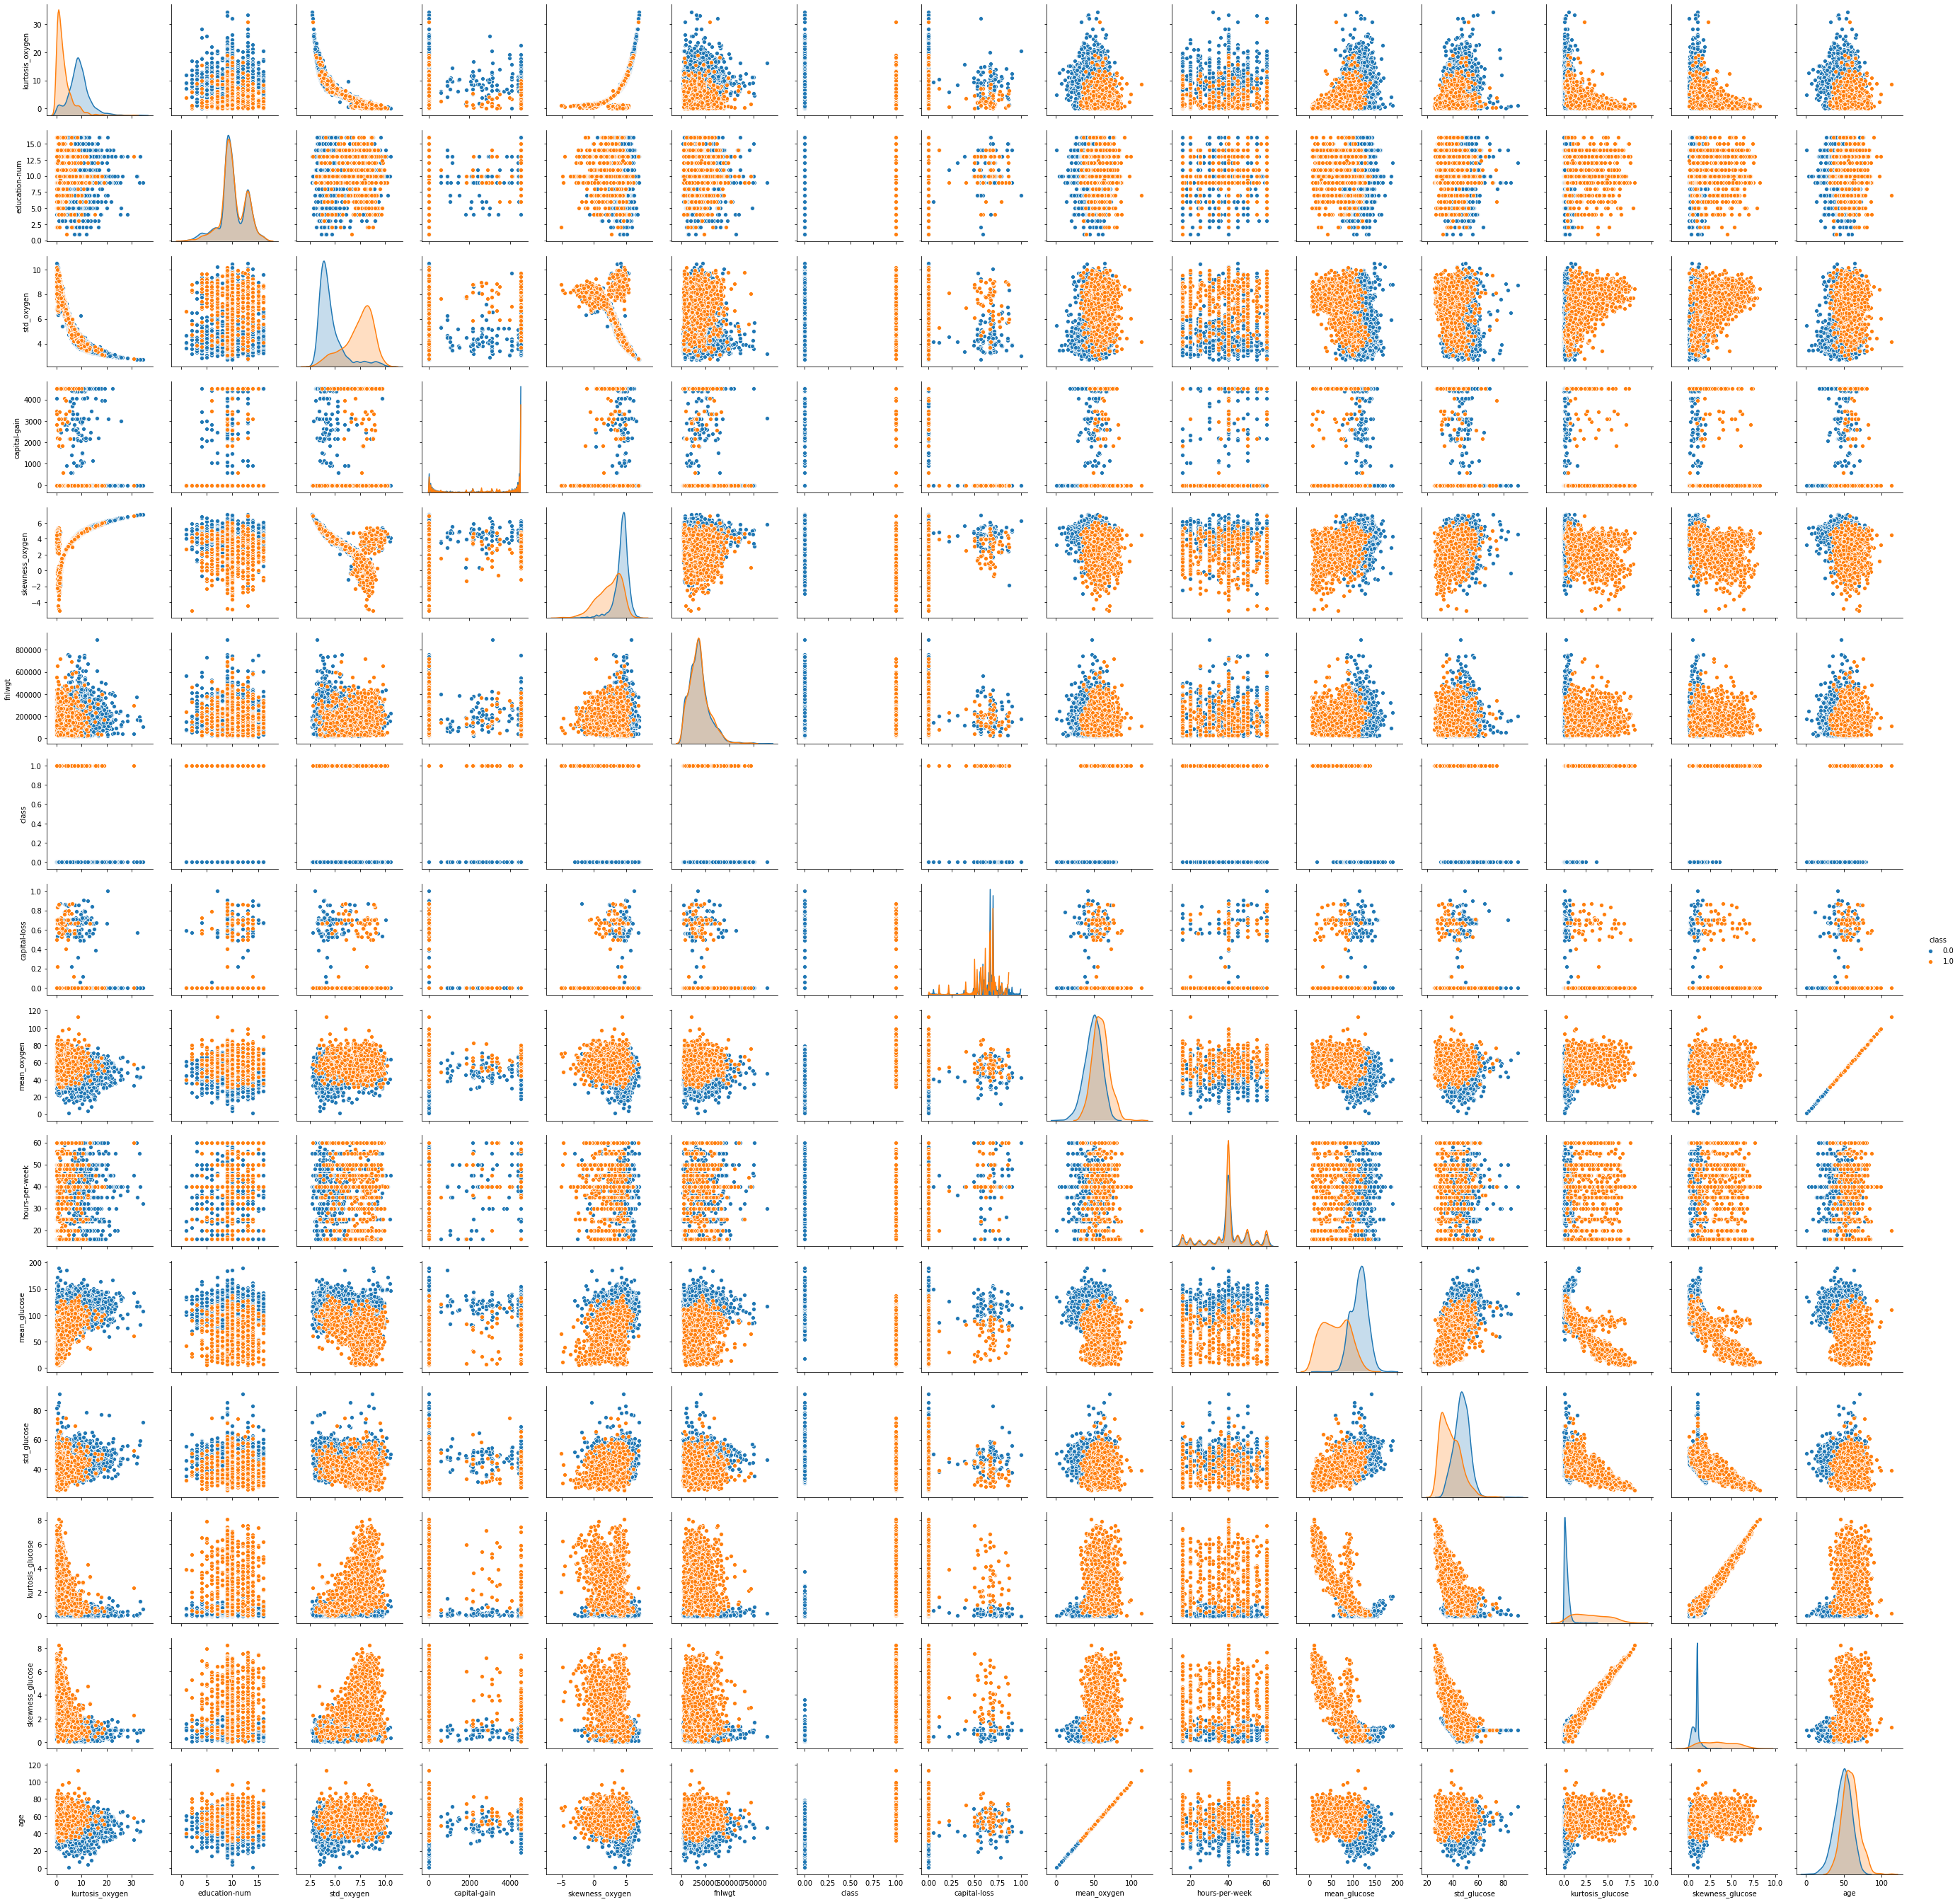

In [507]:
sns.pairplot(final_dataset, hue="class")

Pairploty po doplneni hodnot

In [508]:
final_dataset.isna().sum().sum()

5

In [509]:
final_dataset = drop_class(final_dataset,'class')

odstranenie riadkov, kde nemam priradene labele

In [510]:
final_dataset.isna().sum().sum()

0

Cely dataset je uz vycisteny

## Podme sa pozriet cez parovu analyzu

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3f7457f0>,
      dtype=object)

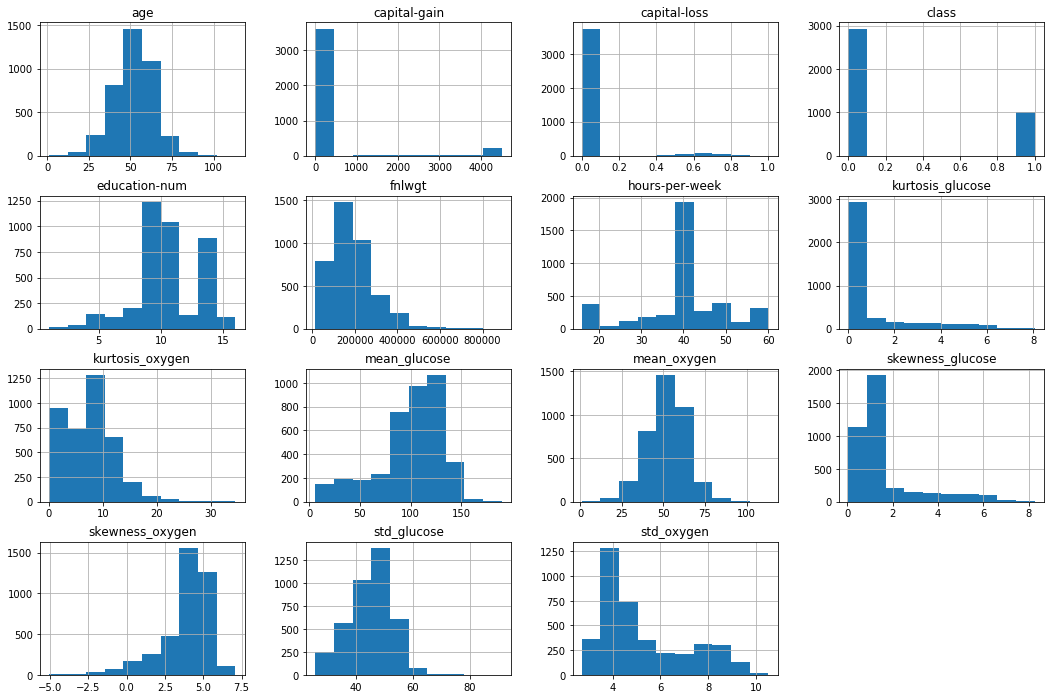

In [512]:
final_dataset.hist(figsize=(18,12))

Doplnenim hodnot sa nam rozdelenie nepokazilo

### Podme zrobit parovu analyzu

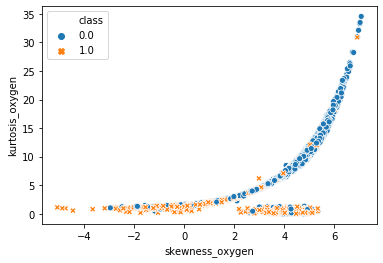

In [513]:
sns.scatterplot(x="skewness_oxygen", y="kurtosis_oxygen",hue="class", style="class", data=final_dataset)

Porovnanie grafov pred a po uprave. Hore je graf po uprave. Je vidiet ze nam tam vznikol ako keby ostrovcek, ktori je oddeleny

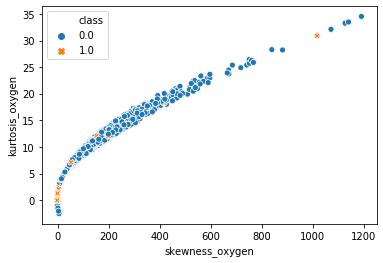

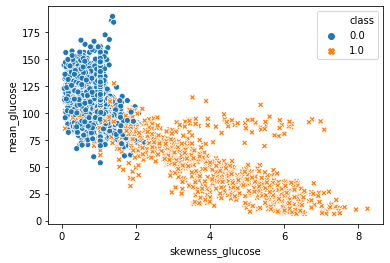

In [514]:
sns.scatterplot(x="skewness_glucose", y="mean_glucose",hue="class", style="class", data=final_dataset)

Vidime ze v strede mame nejake hodnoty ktore tam pred tim neboli. Za nasledok to moze mat doplnenie medianom/priemerom. Dolny obrazok stiahnuty z analyzi

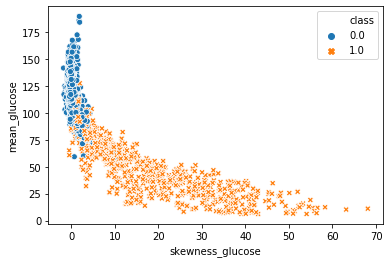

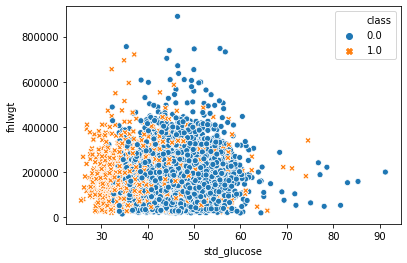

In [515]:
sns.scatterplot(x="std_glucose", y="fnlwgt",hue="class", style="class", data=final_dataset)

Z grafu je vidno, ze hodnoty nie su rozdelene na tolko zhlukov ako boli pri prieskumnej analyze

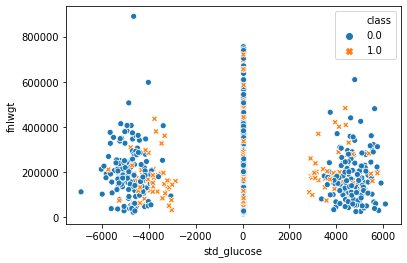

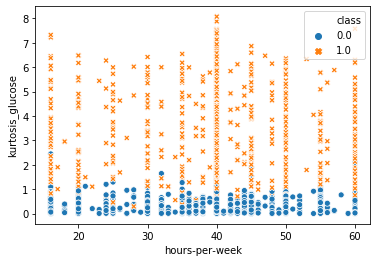

In [516]:
sns.scatterplot(x="hours-per-week", y="kurtosis_glucose",hue="class", style="class", data=final_dataset)

Na tomto obrazku nejaku extra zmenu nie je vidiet. Akurat sa odstranilo zopar zapornych hodnot. Medzi atributmi nevidno zavislost

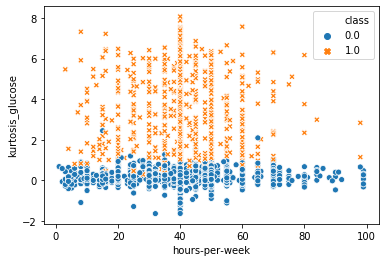

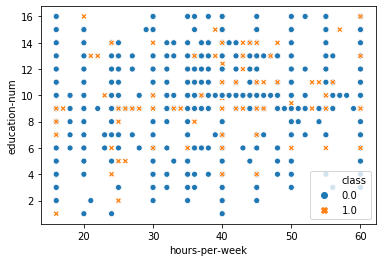

In [517]:
sns.scatterplot(x="hours-per-week", y="education-num",hue="class", style="class", data=final_dataset)

Pri tomto grafe nie je taktiez viditelna nejaka extra zmena, vyzera ze iba trochu zredlo zahustenie grafu. Medzi danymi atributmi nevidno ziadnu zavislost

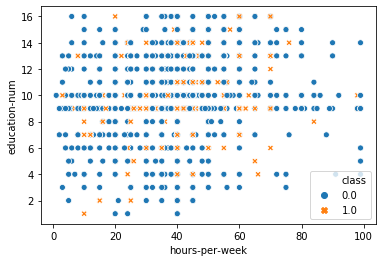

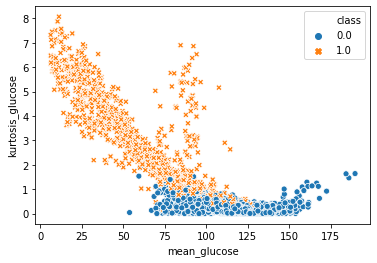

In [518]:
sns.scatterplot(x="mean_glucose", y="kurtosis_glucose",hue="class", style="class", data=final_dataset)

Z grafu je vidno ze v strede pribudol zhluk. Zaujimave je ze zhluk je charakteristicky triedou, ktora ma cukrovku.

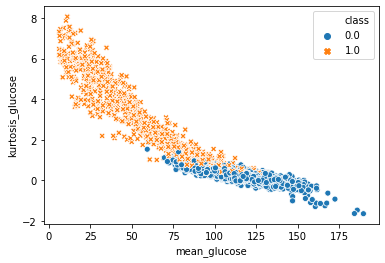

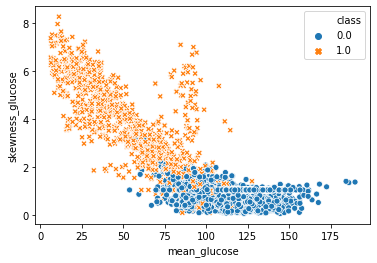

In [519]:
sns.scatterplot(x="mean_glucose", y="skewness_glucose",hue="class", style="class", data=final_dataset)

Podobne ako v predchadzajucom grafe, aj tuto pribudol novy zhluk v strede. Stale by sa dalo povedat ze je nejaka kvadraticka zavislost medzi atributmi

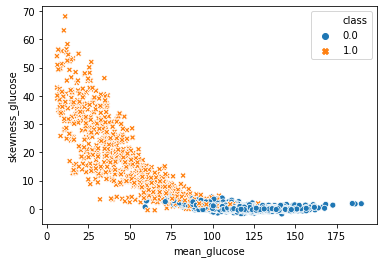

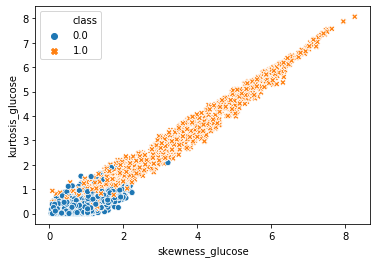

In [520]:
sns.scatterplot(x="skewness_glucose", y="kurtosis_glucose",hue="class", style="class", data=final_dataset)

Uprava(doplnenie chybajucich atributov a normalizacia) atributov dosiahla ze z kvadratickej zavislosti sa stala linearna. Medzi atributmi je zavislost

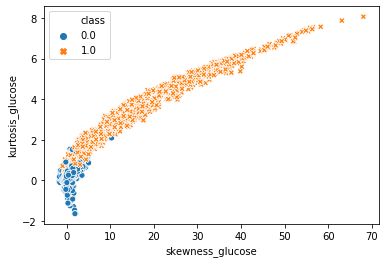

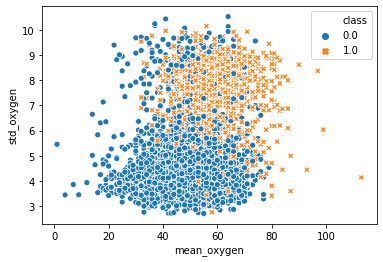

In [521]:
sns.scatterplot(x="mean_oxygen", y="std_oxygen",hue="class", style="class", data=final_dataset)

V prieskumnej analyze tu bol mensi naznak paraboly. Po uprave to vsak vyzera tak ze medzi timito atributmi nie je zavislost

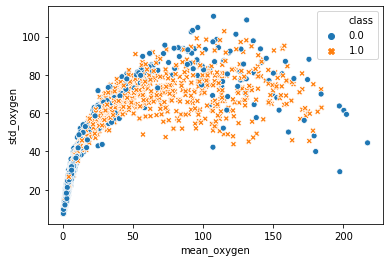

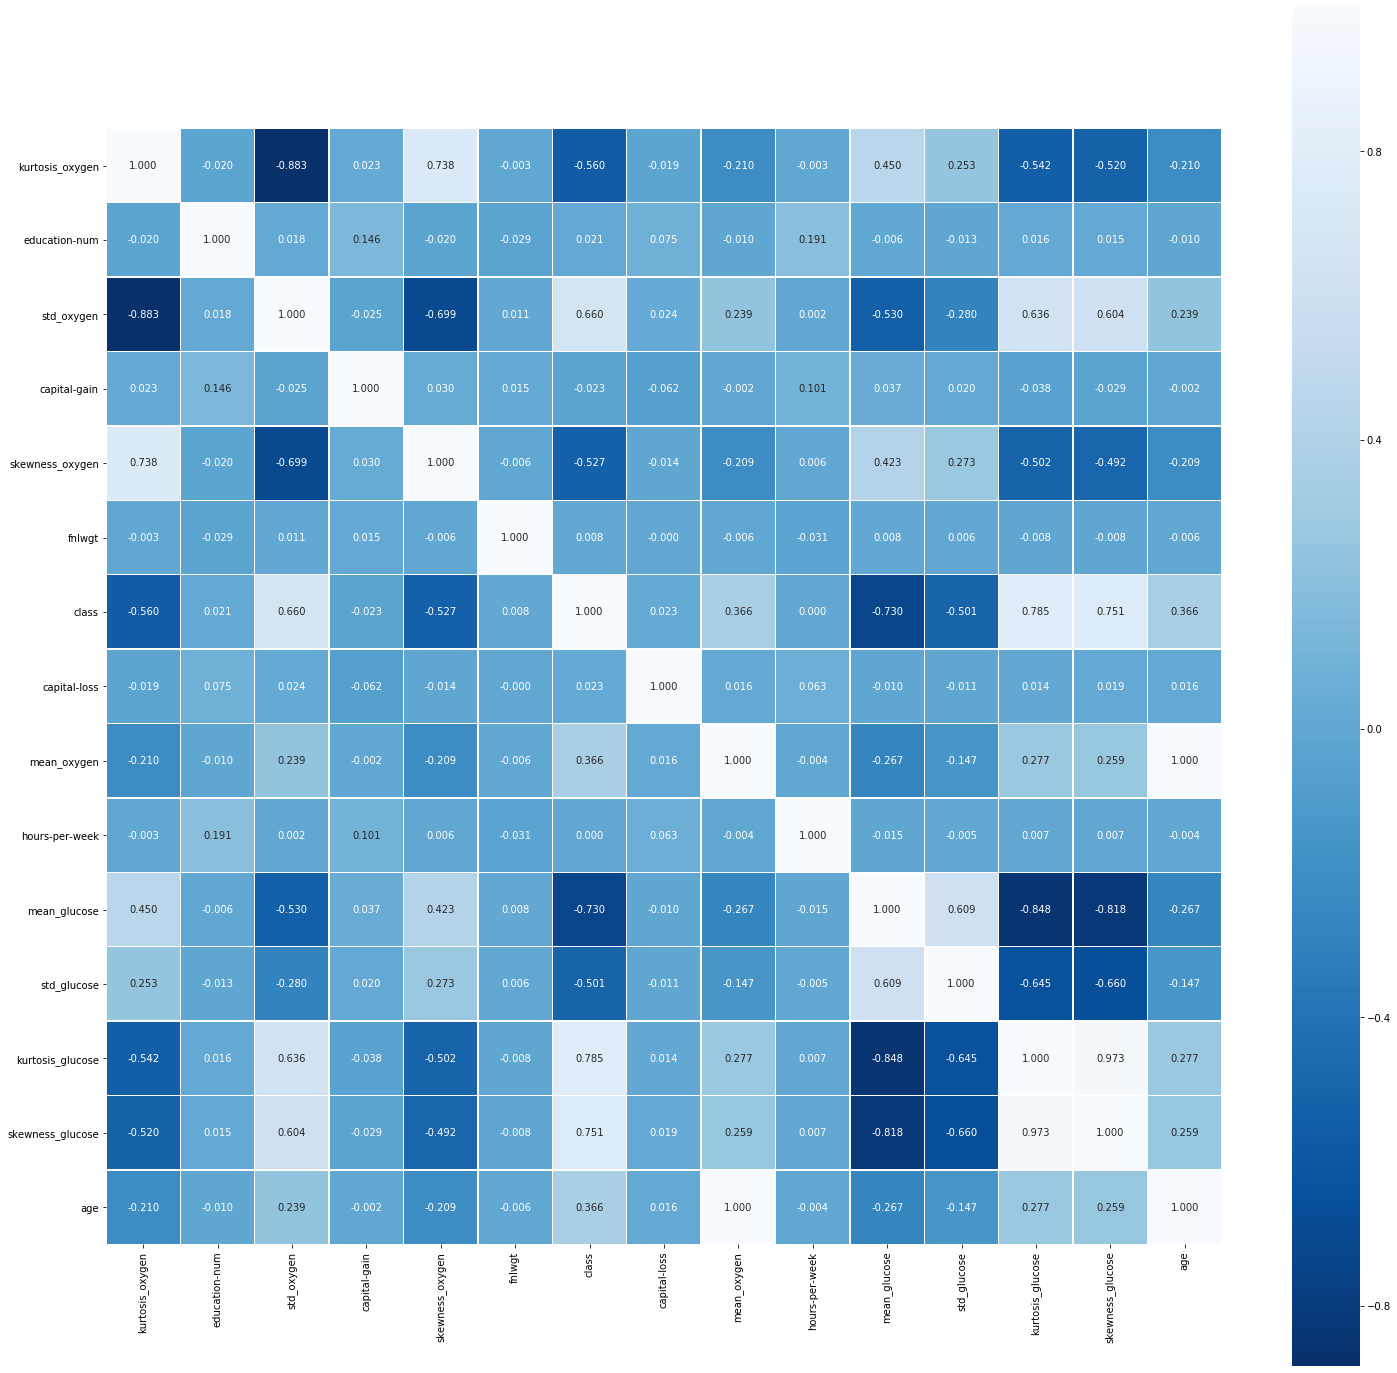

In [522]:
corrmat=final_dataset.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corrmat, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');

Pri porovnani korelacnych matic sa korelacia pri niektorych atributoch zlepsila, pri niektorych sa zas zhorsila

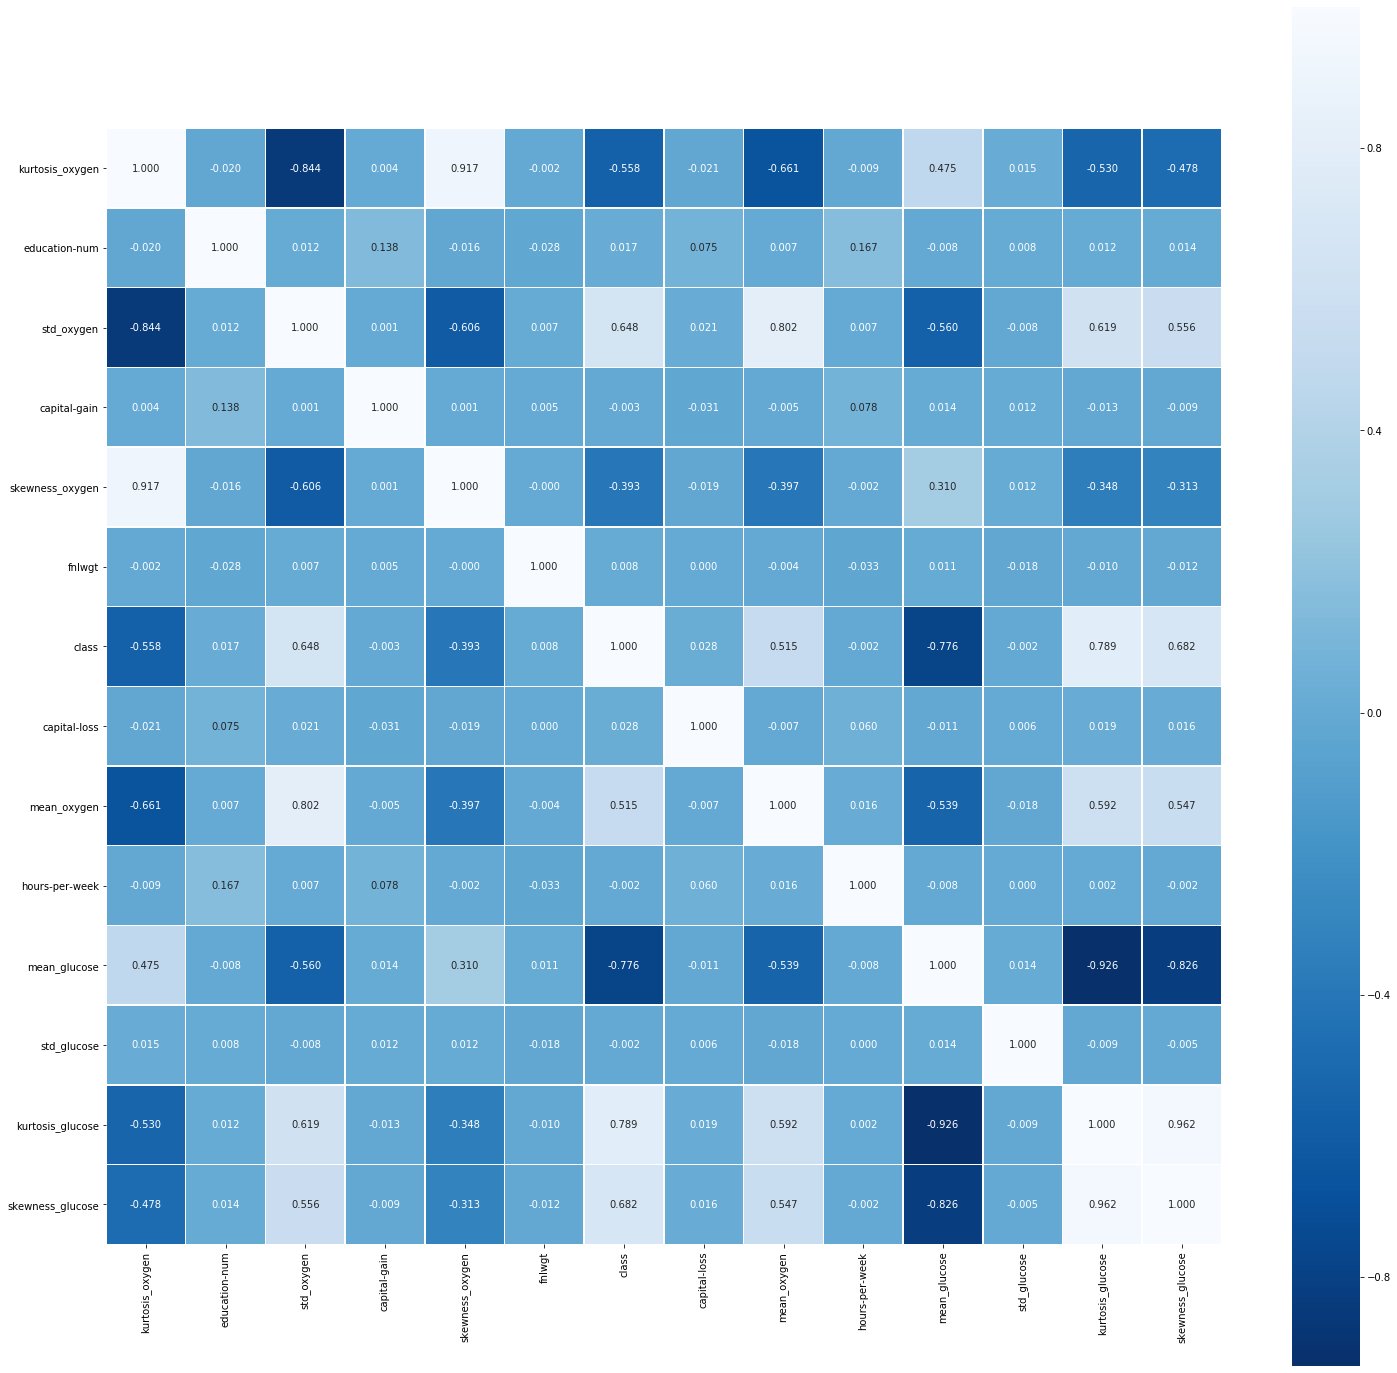

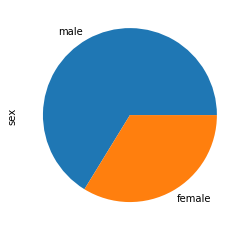

In [534]:
final_dataset.sex.value_counts().plot(kind='pie')

Pomer pohlavia sa nam po doplneni chybajucich atributov vyrazne nezmenil

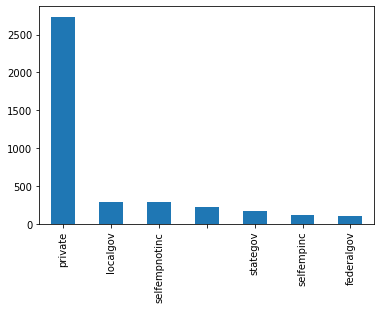

In [527]:
final_dataset.workclass.value_counts().plot(kind='bar')

Porovnanie pre atribut workclass. Je vidiet ze sa zmensilo mnozstvo nazvov jednotlivych zaznamov. Zaznam vyssie pri ktorom nie je nazov sme nechali pre nedefinovane zamestnanie

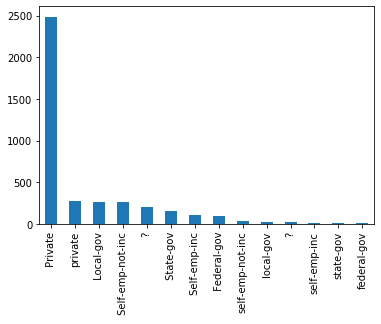

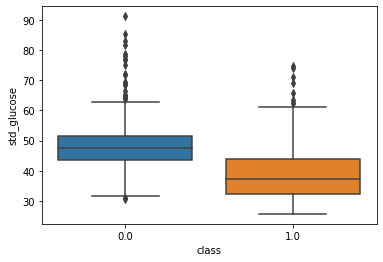

In [531]:
sns.boxplot("class", "std_glucose", data=final_dataset)

Z boxplotu je vidiet, ze predelenie konstantou pomohlo pre lepsie rozlozenie hodnot daneho atributu

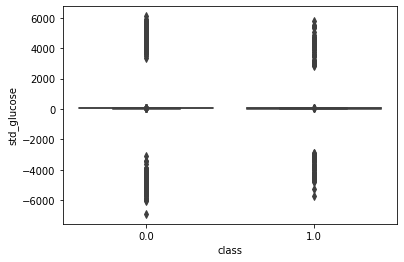

# Zhodnotenie

Pri tomto projekte sme sa pokusali naplnit vsetky poziadavky, ktore vyplivali zo zadania. Identifikovane problemi z prieskumnej analyzi sme sa pokusili odstranit a vyriesit. V prvej casti sme normalizovali dane hodnoty a odstranovali outlyerov. Druha cast zachytava doplnenie chybajucich a v tretej casti sme vizualizovali jednotlive vysledky.  

Na zaciatku sme nastavili ciselne hodnoty na numericke (nie vsetky boli numericke) a neciselne hodnoty na stringy. U stringovych hodnot sa spravili upravi ako lower case a rozdelenie na jednotny format. Taktiez sa dopocitali chybajuce roky a rozdelil sa stlpec med info na viac stlpcov. 

Pri normalizovani sme si vyskusali viacero strategii. Pouzili sme logaritmicku normalizaciu, normalizaciu pomocou odmocniny, minmax normalizaciu. Nasledne sme pre niektore atributy odstranili outlyerov pomocou 5% a 95% kvartilu (opis ako sme to robili je spomenuty vyssie).  

Nasledne sme sa pustili do doplnania chybajucich hodnot. Vyskusali sme si viacero moznych sposobov ako napr. doplnenie medianom, doplnenie priemerom, doplnenie najcastejsie sa vyskytujucim prvkom (pouzite najme pri kategorickych atributoch), a na zaver sme vsetky chybajuce hodnoty doplnili pomocou algoritmu knn.  
V zavere sme sa pustili do vizualizacie a porovnavali grafy vykreslene z prieskumnej analyzi a grafy vykreslene z predspracovania.  

Pri pisani kodu sme dbali aj na znovu pouzitelnost. V zadani sme si vyskusali pipelinu, a vsetky dolezite atributi sme si pametali v triedach. Islo o hodnoty ako median priemer, najcastejsie sa vyskytujuci prvok a pod, aby sme ich vedeli nasledne pouzit pri testovacej sade. Ostatny kod sme sa snazili pisat do funkcii, ktore su vo vrchnej casti programu.  

Pri pisani sme sa snazili vsetko dokumentovat a opisat kazdy krok co robi. Preto su aj prikazi rozdelene do viacerych riadkov(kvoli prehladnosti). V nasledujucej faze planujeme mat do 5 riadkov, ktore ked sa spustia bude cely dataset vycisteny, ci uz trenovaci alebo testovaci.  